In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp '/content/drive/My Drive/Colab Notebooks/nlp project/kaggle.json' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!ls ~/.kaggle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
kaggle.json


In [ ]:
!kaggle datasets download -d dfydata/wordnet-dictionary-thesaurus-files-in-csv-format
!unzip -q wordnet-dictionary-thesaurus-files-in-csv-format.zip -d /content/wordnet

Dataset URL: https://www.kaggle.com/datasets/dfydata/wordnet-dictionary-thesaurus-files-in-csv-format
License(s): CC0-1.0
  0% 0.00/11.1M [00:00<?, ?B/s]
100% 11.1M/11.1M [00:00<00:00, 1.11GB/s]


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import random
from collections import defaultdict

In [ ]:
df = pd.read_csv('/content/wordnet/WordNet-DictionaryThesaurus/WordnetSynonyms.csv')

df = df.dropna(subset=['Word', 'Synonyms'])

df['Word'] = df['Word'].apply(lambda w: w.strip().lower())
df['Synonyms'] = df['Synonyms'].apply(lambda s: [w.strip().lower() for w in s.replace(';', ',').split(',') if w.strip().isalpha()])

clue_targets = {row['Word']: row['Synonyms'] for _, row in df.iterrows() if len(row['Synonyms']) >= 2}
print(f"Clues with >=2 synonyms: {len(clue_targets)}")
example_clue = next(iter(clue_targets))
print(f"Example: '{example_clue}' → {clue_targets[example_clue]}")

<ipython-input-4-b570540b44b6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Word'] = df['Word'].apply(lambda w: w.strip().lower())


Clues with >=2 synonyms: 35326
Example: 'a-one' → ['ace', 'crack', 'super', 'tiptop', 'topnotch', 'tops']


In [ ]:
vocab = set(clue_targets.keys())
for syn_list in clue_targets.values():
    vocab.update(syn_list)

for n in range(1, 6):
    vocab.add(str(n))
vocab = sorted(vocab)
word2id = {word: idx for idx, word in enumerate(vocab)}
id2word = {idx: word for word, idx in word2id.items()}

In [ ]:
all_clues = list(clue_targets.keys())

def sample_board(clue):
    max_targets = min(3, len(clue_targets[clue]))
    N = random.randint(2, max_targets) if max_targets > 1 else 1
    target_words = clue_targets[clue][:N]
    board_words = target_words.copy()
    while len(board_words) < 25:
        candidate = random.choice(vocab)
        if candidate not in board_words and candidate != clue:
            board_words.append(candidate)
    random.shuffle(board_words)
    return board_words, target_words, N

sample_clue = random.choice(all_clues)
board, targets, N = sample_board(sample_clue)
print(f"Clue: {sample_clue} (N={N})")
print(f"Board (25 words): {board[:]}")
print(f"Target words: {targets}")

Clue: field glasses (N=3)
Board (25 words): ['pelecypodous', 'domesticise', 'tachygraphy', 'baseborn', 'vie', 'cackle', 'desalination', 'center', 'federita', 'glass', 'spyhole', 'push around', 'binoculars', 'seating room', 'zoroastrianism', 'parts', 'desertion', 'spyglass', 'pair of tweezers', 'climb-down', 'rehear', 'bachelor of arts', 'reason out', 'the tempter', 'bulwark']
Target words: ['binoculars', 'glass', 'spyglass']


In [7]:
class BoardAssocDataset(Dataset):
    def __init__(self, clues, clue_targets, vocab, board_size=25, max_targets=3):
        self.clues = clues
        self.clue_targets = clue_targets
        self.vocab = vocab
        self.board_size = board_size
        self.max_targets = max_targets

    def __len__(self):
        return len(self.clues)

    def __getitem__(self, idx):
        clue = self.clues[idx]
        targets = [w for w in self.clue_targets[clue] if w in self.vocab][:self.max_targets]
        board = set(targets)
        while len(board) < self.board_size:
            candidate = random.choice(list(self.vocab))
            if candidate not in board and candidate != clue:
                board.add(candidate)
        board = list(board)
        random.shuffle(board)
        clue_idx = word2id.get(clue, word2id["unknown"]) if "unknown" in word2id else word2id[list(word2id.keys())[0]]
        board_idx = [word2id.get(w, word2id["unknown"]) if "unknown" in word2id else word2id[list(word2id.keys())[0]] for w in board]
        input_ids = [clue_idx] + board_idx
        labels = [1 if w in targets else 0 for w in board]
        return torch.tensor(input_ids, dtype=torch.long), torch.tensor(labels, dtype=torch.float)


In [8]:
clues = list(clue_targets.keys())
random.shuffle(clues)
split = int(0.9 * len(clues))
train_clues = clues[:split]
val_clues = clues[split:]

train_dataset = BoardAssocDataset(train_clues, clue_targets, vocab, board_size=25, max_targets=3)
val_dataset   = BoardAssocDataset(val_clues, clue_targets, vocab, board_size=25, max_targets=3)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
class MiniTransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, n_heads=4, n_layers=3, pad_idx=0, board_size=25):
        super().__init__()
        self.clue_embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.board_embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=4*embed_dim, dropout=0.1, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.fc = nn.Linear(embed_dim, 1)
        self.board_size = board_size

    def forward(self, input_ids):
        clue_id = input_ids[:, 0].unsqueeze(1)
        board_ids = input_ids[:, 1:]
        clue_emb = self.clue_embed(clue_id)
        board_emb = self.board_embed(board_ids)
        x = torch.cat([clue_emb, board_emb], dim=1)
        x = self.transformer_encoder(x)
        board_x = x[:, 1:, :]
        logits = self.fc(board_x).squeeze(-1)
        return logits

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = MiniTransformerModel(
    vocab_size=len(vocab), embed_dim=128, n_heads=4, n_layers=3, pad_idx=0, board_size=25
).to(device)

Using device: cuda


In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
for epoch in range(1, 51):
    model.train()
    total_loss = 0.0
    for batch_inputs, batch_targets in train_loader:
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)
        logits = model(batch_inputs)
        loss = criterion(logits, batch_targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_inputs.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Supervised Epoch {epoch}: train loss = {avg_loss:.4f}")


Supervised Epoch 1: train loss = 0.2275
Supervised Epoch 2: train loss = 0.2259
Supervised Epoch 3: train loss = 0.2245
Supervised Epoch 4: train loss = 0.2232
Supervised Epoch 5: train loss = 0.2212
Supervised Epoch 6: train loss = 0.2190
Supervised Epoch 7: train loss = 0.2182
Supervised Epoch 8: train loss = 0.2164
Supervised Epoch 9: train loss = 0.2145
Supervised Epoch 10: train loss = 0.2131


In [ ]:
model.eval()
top1_correct = 0
top2_correct = 0
top3_correct = 0
total = 0

for batch_inputs, batch_targets in val_loader:
    batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
    logits = model(batch_inputs)
    probs = torch.sigmoid(logits)
    topk_indices = torch.topk(probs, k=3, dim=1).indices  # [batch, 3]

    for i in range(batch_targets.size(0)):
        targets_idx = batch_targets[i].nonzero().squeeze(-1).tolist()
        if isinstance(targets_idx, int): targets_idx = [targets_idx]
        pred1 = [topk_indices[i][0].item()]
        pred2 = topk_indices[i][:2].tolist()
        pred3 = topk_indices[i][:3].tolist()

        if any(idx in targets_idx for idx in pred1):
            top1_correct += 1
        if any(idx in targets_idx for idx in pred2):
            top2_correct += 1
        if any(idx in targets_idx for idx in pred3):
            top3_correct += 1
        total += 1

print(f"Top-1 board accuracy: {100*top1_correct/total:.2f}%")
print(f"Top-2 board accuracy: {100*top2_correct/total:.2f}%")
print(f"Top-3 board accuracy: {100*top3_correct/total:.2f}%")


Top-1 board accuracy: 35.75%
Top-2 board accuracy: 45.49%
Top-3 board accuracy: 52.02%


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/nlp/guesser_wordnet_supervised50.pth')
print("Model (supervised pretrain) saved.")

Model (supervised pretrain) saved.


In [ ]:
import pickle

with open('/content/drive/MyDrive/Colab Notebooks/nlp/word2id.pkl', 'wb') as f:
    pickle.dump(word2id, f)

In [ ]:
import pickle

with open('/content/drive/My Drive/Colab Notebooks/nlp project/word2id.pkl', 'rb') as f:
    word2id = pickle.load(f)
id2word = {idx: word for word, idx in word2id.items()}
vocab = list(word2id.keys())

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MiniTransformerModel(
    vocab_size=len(word2id),
    embed_dim=128,
    n_heads=4,
    n_layers=3,
    pad_idx=0,
    board_size=25
)
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/nlp project/guesser_wordnet_supervised50.pth'))
model.to(device)
model.eval()

MiniTransformerModel(
  (clue_embed): Embedding(40339, 128, padding_idx=0)
  (board_embed): Embedding(40339, 128, padding_idx=0)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
all_clues = list(clue_targets.keys())

In [ ]:
print(type(all_clues))

<class 'list'>


asd


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=2e-4)

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

def train_model(num_iterations=30000, batch_size=64, supervised_interval=100, alpha=0.2):
    global optimizer
    model.train()
    baseline = 0.0
    supervised_loader_iter = iter(train_loader)
    for it in range(1, num_iterations+1):
        batch_log_probs = []
        batch_rewards = []
        batch_probs = []
        supervised_inputs = []
        supervised_targets = []
        for b in range(batch_size):
            clue = random.choice(all_clues)
            board, target_words, N = sample_board(clue)
            seq_tokens = [clue] + board
            seq_ids = [word2id.get(token, 0) for token in seq_tokens]
            seq_tensor = torch.tensor(seq_ids, dtype=torch.long, device=device).unsqueeze(0)
            logits = model(seq_tensor)
            probs = torch.softmax(logits[0], dim=-1)
            batch_probs.append(probs)

            selected_log_prob = 0.0
            selected_indices = []
            current_probs = probs.clone()
            for _ in range(len(target_words)):
                idx = torch.multinomial(current_probs, num_samples=1).item()
                selected_indices.append(idx)
                selected_log_prob += torch.log(current_probs[idx] + 1e-10)
                current_probs[idx] = 0.0
                if _ < len(target_words) - 1:
                    current_probs = current_probs / current_probs.sum()
            guessed_words = [board[i] for i in selected_indices]
            correct = sum(1 for w in guessed_words if w in target_words)
            wrong = len(target_words) - correct
            reward = correct - 0.5 * wrong
            batch_log_probs.append(selected_log_prob)
            batch_rewards.append(reward)

            board_target = [1 if w in target_words else 0 for w in board]
            supervised_inputs.append(seq_ids)
            supervised_targets.append(board_target)

        batch_log_probs = torch.stack(batch_log_probs)
        batch_rewards = torch.tensor(batch_rewards, dtype=torch.float, device=device)
        avg_reward = float(batch_rewards.mean().item())
        baseline = 0.9 * baseline + 0.1 * avg_reward
        advantages = batch_rewards - baseline
        policy_loss = - (advantages * batch_log_probs).mean()

        supervised_inputs = torch.tensor(supervised_inputs, dtype=torch.long, device=device)  # [batch, seq_len]
        supervised_targets = torch.tensor(supervised_targets, dtype=torch.float, device=device)  # [batch, board_size]
        logits = model(supervised_inputs)  # [batch, board_size]
        sup_loss = F.binary_cross_entropy_with_logits(logits, supervised_targets)

        total_loss = policy_loss + alpha * sup_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if it % 100 == 0:
            print(f"Iter {it}/{num_iterations} - Avg reward: {avg_reward:.2f} | Sup loss: {sup_loss.item():.4f}")

        if it % supervised_interval == 0:
            try:
                supervised_batch = next(supervised_loader_iter)
            except StopIteration:
                supervised_loader_iter = iter(train_loader)
                supervised_batch = next(supervised_loader_iter)
            batch_inputs, batch_targets = supervised_batch
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)
            optimizer.zero_grad()
            logits = model(batch_inputs)
            sup_loss = F.binary_cross_entropy_with_logits(logits, batch_targets.float())
            sup_loss.backward()
            optimizer.step()
            print(f"[{it}] Supervised batch train loss: {sup_loss.item():.4f}")

        if it % 500 == 0:
            print(f"Clue: {clue} | Board: {board}")
            print(f"Target words: {target_words}")
            print(f"Guessed words: {guessed_words}")
            print(f"Correct: {correct}, Wrong: {wrong}")

In [31]:
train_model(num_iterations=30000, batch_size=64)

Iter 100/30000 - Avg reward: -0.05 | Sup loss: 0.2886
[100] Supervised batch train loss: 0.2841
Iter 200/30000 - Avg reward: 0.23 | Sup loss: 0.2742
[200] Supervised batch train loss: 0.3031
Iter 300/30000 - Avg reward: 0.07 | Sup loss: 0.3021
[300] Supervised batch train loss: 0.2459
Iter 400/30000 - Avg reward: 0.21 | Sup loss: 0.3292
[400] Supervised batch train loss: 0.3200
Iter 500/30000 - Avg reward: 0.51 | Sup loss: 0.3721
[500] Supervised batch train loss: 0.4872
Clue: invalidator | Board: ['profusion', 'nullifier', 'class mastigophora', 'si', 'falsehood', 'voider', 'mina', 'rapscallion', 'family allioniaceae', 'untier', 'afrikaans', 'hemipterous insect', 'doctor of music', 'falkner', 'jubilantly', 'well-off', 'theatregoer', 'hole-and-corner', 'storehouse', 'second coming of christ', 'groundbreaking', 'winded', 'corset', 'podiatrist', 'trio']
Target words: ['voider', 'nullifier']
Guessed words: ['voider', 'falsehood']
Correct: 1, Wrong: 1
Iter 600/30000 - Avg reward: 0.12 | Sup

In [32]:
model.eval()
top1_correct = 0
top2_correct = 0
top3_correct = 0
total = 0

for batch_inputs, batch_targets in val_loader:
    batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
    logits = model(batch_inputs)
    probs = torch.sigmoid(logits)
    topk_indices = torch.topk(probs, k=3, dim=1).indices  # [batch, 3]

    for i in range(batch_targets.size(0)):
        targets_idx = batch_targets[i].nonzero().squeeze(-1).tolist()
        if isinstance(targets_idx, int): targets_idx = [targets_idx]
        pred1 = [topk_indices[i][0].item()]
        pred2 = topk_indices[i][:2].tolist()
        pred3 = topk_indices[i][:3].tolist()

        if any(idx in targets_idx for idx in pred1):
            top1_correct += 1
        if any(idx in targets_idx for idx in pred2):
            top2_correct += 1
        if any(idx in targets_idx for idx in pred3):
            top3_correct += 1
        total += 1

print(f"Top-1 board accuracy: {100*top1_correct/total:.2f}%")
print(f"Top-2 board accuracy: {100*top2_correct/total:.2f}%")
print(f"Top-3 board accuracy: {100*top3_correct/total:.2f}%")


Top-1 board accuracy: 46.99%
Top-2 board accuracy: 58.68%
Top-3 board accuracy: 65.95%


In [34]:
torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/nlp project/guesser_wordnet_supervised_RL.pth')
print("Model (RL + supervised pretrain) saved.")


Model (RL + supervised pretrain) saved.


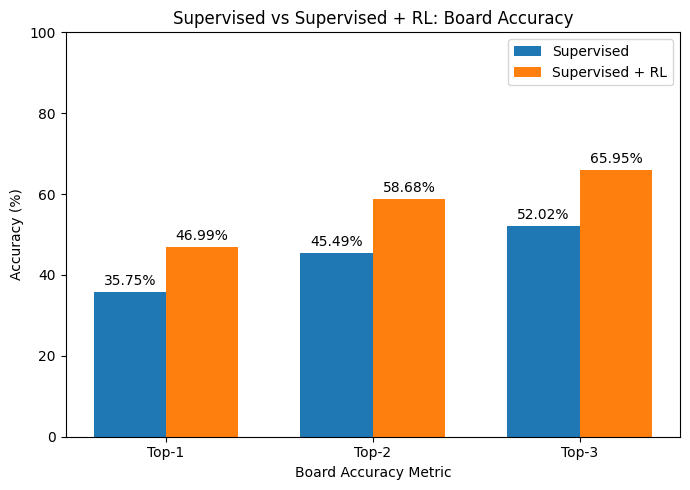

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

supervised_acc = [35.75, 45.49, 52.02]
rl_acc = [46.99, 58.68, 65.95]

labels = ['Top-1', 'Top-2', 'Top-3']
x = np.arange(len(labels))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(7,5))

rects1 = ax.bar(x - bar_width/2, supervised_acc, bar_width, label='Supervised')
rects2 = ax.bar(x + bar_width/2, rl_acc, bar_width, label='Supervised + RL')

ax.set_xlabel('Board Accuracy Metric')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Supervised vs Supervised + RL: Board Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0, 100)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


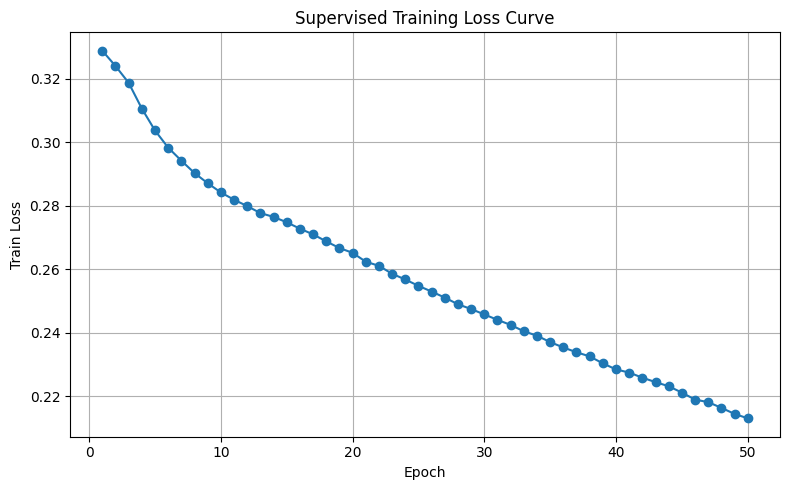

In [ ]:
import matplotlib.pyplot as plt

loss_values = [
    0.3288, 0.3240, 0.3187, 0.3106, 0.3037, 0.2983, 0.2942, 0.2903, 0.2871, 0.2842,
    0.2819, 0.2799, 0.2777, 0.2765, 0.2748, 0.2728, 0.2710, 0.2688, 0.2667, 0.2652,
    0.2624, 0.2611, 0.2586, 0.2568, 0.2548, 0.2530, 0.2511, 0.2490, 0.2475, 0.2458,
    0.2441, 0.2425, 0.2405, 0.2391, 0.2371, 0.2354, 0.2339, 0.2326, 0.2304, 0.2285,
    0.2275, 0.2259, 0.2245, 0.2232, 0.2212, 0.2190, 0.2182, 0.2164, 0.2145, 0.2131
]

epochs = list(range(1, 51))

plt.figure(figsize=(8, 5))
plt.plot(epochs, loss_values, marker='o')
plt.title('Supervised Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.grid(True)
plt.tight_layout()
plt.show()


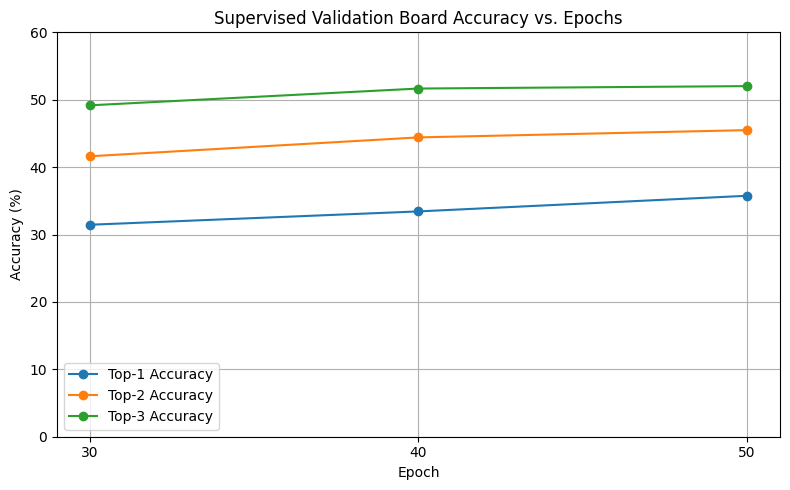

In [37]:
epochs_acc = [30, 40, 50]
top1_acc = [31.45, 33.43, 35.75]
top2_acc = [41.61, 44.41, 45.49]
top3_acc = [49.17, 51.66, 52.02]

plt.figure(figsize=(8, 5))
plt.plot(epochs_acc, top1_acc, marker='o', label='Top-1 Accuracy')
plt.plot(epochs_acc, top2_acc, marker='o', label='Top-2 Accuracy')
plt.plot(epochs_acc, top3_acc, marker='o', label='Top-3 Accuracy')

plt.title('Supervised Validation Board Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(epochs_acc)
plt.ylim(0, 60)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


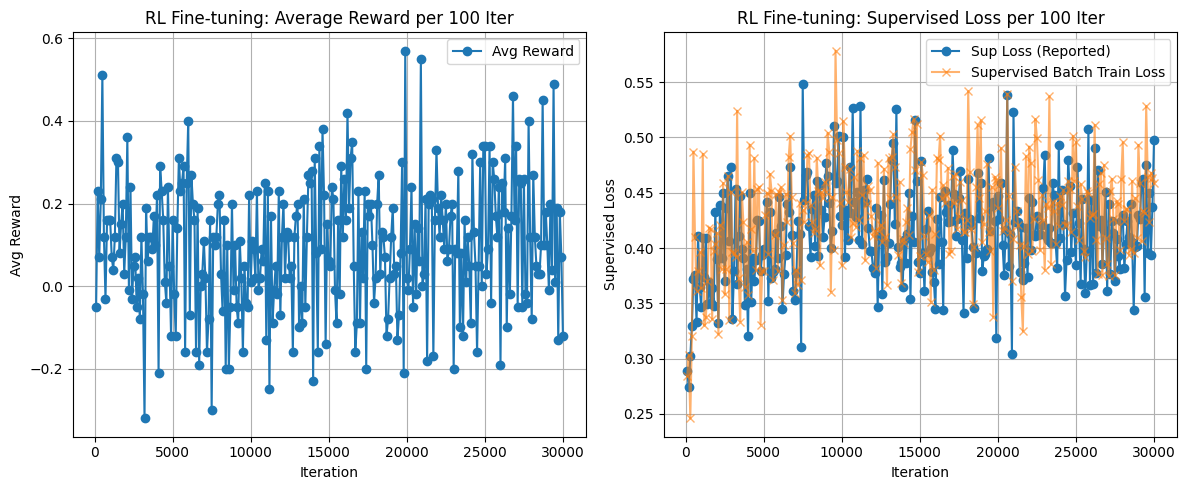

In [ ]:
import matplotlib.pyplot as plt
import re

log = '''
Iter 100/30000 - Avg reward: -0.05 | Sup loss: 0.2886
[100] Supervised batch train loss: 0.2841
Iter 200/30000 - Avg reward: 0.23 | Sup loss: 0.2742
[200] Supervised batch train loss: 0.3031
Iter 300/30000 - Avg reward: 0.07 | Sup loss: 0.3021
[300] Supervised batch train loss: 0.2459
Iter 400/30000 - Avg reward: 0.21 | Sup loss: 0.3292
[400] Supervised batch train loss: 0.3200
Iter 500/30000 - Avg reward: 0.51 | Sup loss: 0.3721
[500] Supervised batch train loss: 0.4872
Clue: invalidator | Board: ['profusion', 'nullifier', 'class mastigophora', 'si', 'falsehood', 'voider', 'mina', 'rapscallion', 'family allioniaceae', 'untier', 'afrikaans', 'hemipterous insect', 'doctor of music', 'falkner', 'jubilantly', 'well-off', 'theatregoer', 'hole-and-corner', 'storehouse', 'second coming of christ', 'groundbreaking', 'winded', 'corset', 'podiatrist', 'trio']
Target words: ['voider', 'nullifier']
Guessed words: ['voider', 'falsehood']
Correct: 1, Wrong: 1
Iter 600/30000 - Avg reward: 0.12 | Sup loss: 0.3752
[600] Supervised batch train loss: 0.4101
Iter 700/30000 - Avg reward: -0.03 | Sup loss: 0.3328
[700] Supervised batch train loss: 0.3613
Iter 800/30000 - Avg reward: 0.16 | Sup loss: 0.4112
[800] Supervised batch train loss: 0.3789
Iter 900/30000 - Avg reward: 0.16 | Sup loss: 0.3643
[900] Supervised batch train loss: 0.3961
Iter 1000/30000 - Avg reward: 0.16 | Sup loss: 0.3468
[1000] Supervised batch train loss: 0.3637
Clue: sobriquet | Board: ['ulterior', 'decennium', 'cheapness', 'gloam', 'knee pants', 'moniker', 'verifying', 'albinotic', 'travesty', 'cognomen', 'hostler', 'caddish', 'incarcerate', 'nickname', 'legal transfer', 'inured', 'insulating material', 'elicited', 'cerebromeningitis', 'heart', 'traitorously', 'downsizing', 'genus taraktagenos', 'focalize', 'ascendent']
Target words: ['nickname', 'moniker', 'cognomen']
Guessed words: ['nickname', 'moniker', 'inured']
Correct: 2, Wrong: 1
Iter 1100/30000 - Avg reward: 0.07 | Sup loss: 0.4091
[1100] Supervised batch train loss: 0.4852
Iter 1200/30000 - Avg reward: 0.04 | Sup loss: 0.3738
[1200] Supervised batch train loss: 0.3299
Iter 1300/30000 - Avg reward: 0.12 | Sup loss: 0.4094
[1300] Supervised batch train loss: 0.3372
Iter 1400/30000 - Avg reward: 0.31 | Sup loss: 0.3493
[1400] Supervised batch train loss: 0.3702
Iter 1500/30000 - Avg reward: 0.30 | Sup loss: 0.3695
[1500] Supervised batch train loss: 0.4182
Clue: gear lever | Board: ['wind generator', 'triplet', 'cursed', 'shifter', 'kilogram', 'philippines', 'exuberantly', 'cheerless', 'dowdiness', 'litchi chinensis', 'gearshift', 'gearstick', 'excruciatingly', 'bedamn', 'concision', 'deccan hemp', 'hands', 'isocarboxazid', 'aloha state', 'almighty', 'clustering', 'whiplike', 'voyeur', 'pashto', 'enigmatically']
Target words: ['gearshift', 'gearstick', 'shifter']
Guessed words: ['gearstick', 'cheerless', 'hands']
Correct: 1, Wrong: 2
Iter 1600/30000 - Avg reward: 0.08 | Sup loss: 0.3502
[1600] Supervised batch train loss: 0.4175
Iter 1700/30000 - Avg reward: 0.15 | Sup loss: 0.3641
[1700] Supervised batch train loss: 0.3357
Iter 1800/30000 - Avg reward: 0.20 | Sup loss: 0.3473
[1800] Supervised batch train loss: 0.3977
Iter 1900/30000 - Avg reward: 0.03 | Sup loss: 0.4330
[1900] Supervised batch train loss: 0.4038
Iter 2000/30000 - Avg reward: 0.12 | Sup loss: 0.3899
[2000] Supervised batch train loss: 0.4136
Clue: capillary artery | Board: ['collecting', 'cavalry sword', 'mindfully', 'arteriole', 'squelcher', 'arteriola', 'trouper', 'chichewa', 'lofty', 'contiguity', 'lamellibranch', 'soybean', 'hard knocks', 'plumose', 'drier', 'immunosuppressive', 'hang-up', 'anise seed', 'discord', 'affront', 'bataan', 'mark antony', 'securer', 'iodin', 'rested']
Target words: ['arteriole', 'arteriola']
Guessed words: ['immunosuppressive', 'drier']
Correct: 0, Wrong: 2
Iter 2100/30000 - Avg reward: 0.36 | Sup loss: 0.3318
[2100] Supervised batch train loss: 0.3222
Iter 2200/30000 - Avg reward: -0.01 | Sup loss: 0.4390
[2200] Supervised batch train loss: 0.4212
Iter 2300/30000 - Avg reward: 0.24 | Sup loss: 0.3907
[2300] Supervised batch train loss: 0.3806
Iter 2400/30000 - Avg reward: -0.03 | Sup loss: 0.4500
[2400] Supervised batch train loss: 0.4587
Iter 2500/30000 - Avg reward: 0.05 | Sup loss: 0.3702
[2500] Supervised batch train loss: 0.3582
Clue: a | Board: ['hcfc', 'damaging', 'redevelopment', 'etiolated', 'urge', 'jinrikisha', 'panjabi', 'order araneae', 'cad', 'ambler', 'angstrom', 'fair to middling', 'accumulate', 'clearing', 'lead', 'retarded', 'order ranunculales', 'scholarly person', 'obsequiously', 'priority', 'second coming', 'axerophthol', 'misunderstanding', 'margin', 'joyousness']
Target words: ['angstrom', 'axerophthol']
Guessed words: ['angstrom', 'lead']
Correct: 1, Wrong: 1
Iter 2600/30000 - Avg reward: 0.07 | Sup loss: 0.4360
[2600] Supervised batch train loss: 0.3806
Iter 2700/30000 - Avg reward: -0.05 | Sup loss: 0.4652
[2700] Supervised batch train loss: 0.4652
Iter 2800/30000 - Avg reward: 0.02 | Sup loss: 0.4059
[2800] Supervised batch train loss: 0.3353
Iter 2900/30000 - Avg reward: -0.08 | Sup loss: 0.4730
[2900] Supervised batch train loss: 0.4510
Iter 3000/30000 - Avg reward: 0.12 | Sup loss: 0.3361
[3000] Supervised batch train loss: 0.3965
Clue: commove | Board: ['joyously', 'professed', 'birr', 'equus hemionus hemionus', 'azerbaijani republic', 'intend', 'thug', 'suasible', 'round scad', 'usher', 'cuprimine', 'cognisable', 'agitate', 'genus darmera', 'neuronic', 'ahorse', 'florin', 'dalliance', 'upthrust', 'ciliary', "log z's", 'hallowmas', 'balancer', 'rouse', 'cardizem']
Target words: ['agitate', 'rouse']
Guessed words: ['cardizem', 'rouse']
Correct: 1, Wrong: 1
Iter 3100/30000 - Avg reward: -0.02 | Sup loss: 0.3792
[3100] Supervised batch train loss: 0.3959
Iter 3200/30000 - Avg reward: -0.32 | Sup loss: 0.4538
[3200] Supervised batch train loss: 0.3923
Iter 3300/30000 - Avg reward: 0.19 | Sup loss: 0.3674
[3300] Supervised batch train loss: 0.5242
Iter 3400/30000 - Avg reward: 0.06 | Sup loss: 0.4105
[3400] Supervised batch train loss: 0.3733
Iter 3500/30000 - Avg reward: 0.12 | Sup loss: 0.4469
[3500] Supervised batch train loss: 0.3335
Clue: conscientiously | Board: ['scaled', 'appellative', 'paving', 'aplomb', 'cattle farm', 'scrupulously', 'patronised', 'holding', 'taxis', 'intemperately', 'monophonic', 'religiously', 'theologiser', 'fortify', 'credentials', 'doriden', 'greet', 'unguent', 'pentagram', 'battue', 'abridgement', 'adjusted', 'fork-like', 'ableism', 'double']
Target words: ['scrupulously', 'religiously']
Guessed words: ['double', 'fortify']
Correct: 0, Wrong: 2
Iter 3600/30000 - Avg reward: 0.12 | Sup loss: 0.3993
[3600] Supervised batch train loss: 0.4504
Iter 3700/30000 - Avg reward: 0.09 | Sup loss: 0.3910
[3700] Supervised batch train loss: 0.4234
Iter 3800/30000 - Avg reward: 0.17 | Sup loss: 0.3480
[3800] Supervised batch train loss: 0.3648
Iter 3900/30000 - Avg reward: 0.10 | Sup loss: 0.3812
[3900] Supervised batch train loss: 0.4052
Iter 4000/30000 - Avg reward: 0.22 | Sup loss: 0.3203
[4000] Supervised batch train loss: 0.3577
Clue: alaska | Board: ['pad of paper', 'imperial gallon', 'iguassu', 'brythonic', 'ak', 'xenicidae', 'tick off', 'moony', 'blat', 'cosmos', 'oldwife', 'chiasmic', 'braincase', 'alaska', 'tending', 'tsine', 'visual', 'melchite', 'box-shaped', 'workable', 'marcher', 'preclusion', 'vitreous', 'canis dingo', 'dick']
Target words: ['alaska', 'ak']
Guessed words: ['ak', 'oldwife']
Correct: 1, Wrong: 1
Iter 4100/30000 - Avg reward: -0.21 | Sup loss: 0.4498
[4100] Supervised batch train loss: 0.4935
Iter 4200/30000 - Avg reward: 0.29 | Sup loss: 0.3515
[4200] Supervised batch train loss: 0.4169
Iter 4300/30000 - Avg reward: 0.23 | Sup loss: 0.3908
[4300] Supervised batch train loss: 0.3971
Iter 4400/30000 - Avg reward: 0.16 | Sup loss: 0.3703
[4400] Supervised batch train loss: 0.4815
Iter 4500/30000 - Avg reward: 0.01 | Sup loss: 0.3895
[4500] Supervised batch train loss: 0.3800
Clue: eroding | Board: ['educational activity', 'informant', 'smart as a whip', 'nonsegregated', 'will power', 'flamboyant', 'fret', 'beard', 'splattering', 'erode', 'fumewort', 'meanwhile', 'terazosin', 'gumptious', 'amerindic', 'gnaw', 'blunder out', 'everyday', 'sahuaro', 'teletype machine', 'segmentation cavity', 'schtick', 'disagree', 'backspace key', 'smartly']
Target words: ['erode', 'gnaw', 'fret']
Guessed words: ['gnaw', 'fret', 'everyday']
Correct: 2, Wrong: 1
Iter 4600/30000 - Avg reward: -0.04 | Sup loss: 0.4252
[4600] Supervised batch train loss: 0.4530
Iter 4700/30000 - Avg reward: 0.24 | Sup loss: 0.4242
[4700] Supervised batch train loss: 0.4551
Iter 4800/30000 - Avg reward: 0.05 | Sup loss: 0.3794
[4800] Supervised batch train loss: 0.3307
Iter 4900/30000 - Avg reward: -0.12 | Sup loss: 0.3933
[4900] Supervised batch train loss: 0.3791
Iter 5000/30000 - Avg reward: 0.16 | Sup loss: 0.3993
[5000] Supervised batch train loss: 0.3791
Clue: mundane | Board: ['arresting', 'british people', 'coriaceous', 'dirty money', 'routine', 'genus satureia', 'monochromia', 'dmitri mendeleyev', 'unmindfulness', 'fusspot', 'nine-fold', 'quotidian', 'tartar', 'shoat', 'everyday', 'deception', 'aegospotamos', 'garrulity', 'playactor', 'litigious', 'heritiera', 'silverbush', 'triplochiton scleroxcylon', 'camping', 'alias']
Target words: ['everyday', 'quotidian', 'routine']
Guessed words: ['everyday', 'quotidian', 'tartar']
Correct: 2, Wrong: 1
Iter 5100/30000 - Avg reward: -0.02 | Sup loss: 0.3962
[5100] Supervised batch train loss: 0.4303
Iter 5200/30000 - Avg reward: -0.12 | Sup loss: 0.4416
[5200] Supervised batch train loss: 0.4500
Iter 5300/30000 - Avg reward: 0.14 | Sup loss: 0.3522
[5300] Supervised batch train loss: 0.3949
Iter 5400/30000 - Avg reward: 0.31 | Sup loss: 0.4327
[5400] Supervised batch train loss: 0.4670
Iter 5500/30000 - Avg reward: 0.23 | Sup loss: 0.3733
[5500] Supervised batch train loss: 0.4519
Clue: rough-cut | Board: ['inexorable', 'shuddery', 'common', 'std', 'european elk', 'interlock', 'blissfulness', 'feodor mikhailovich dostoyevsky', 'remicade', 'hemimetabolic', 'excrement', 'tyke', 'phantasmagorical', 'esquimau', 'oporto', 'dogging', 'sahaptin', 'stochastic variable', 'flaps', 'luscious', 'tidbit', 'cable tramway', 'coarse', 'mishegaas', 'unsatiated']
Target words: ['coarse', 'common']
Guessed words: ['luscious', 'phantasmagorical']
Correct: 0, Wrong: 2
Iter 5600/30000 - Avg reward: 0.25 | Sup loss: 0.3782
[5600] Supervised batch train loss: 0.3707
Iter 5700/30000 - Avg reward: 0.29 | Sup loss: 0.3811
[5700] Supervised batch train loss: 0.4115
Iter 5800/30000 - Avg reward: -0.16 | Sup loss: 0.4137
[5800] Supervised batch train loss: 0.4489
Iter 5900/30000 - Avg reward: 0.25 | Sup loss: 0.3909
[5900] Supervised batch train loss: 0.3792
Iter 6000/30000 - Avg reward: 0.40 | Sup loss: 0.4466
[6000] Supervised batch train loss: 0.4507
Clue: southward | Board: ['mutant', 'self-employed person', 'attend', 'frumpily', 'trappist', 'southerly', 'oral communication', 'cloth', 'pouring', 'sparkleberry', 'wipeout', 'castilla', 'southwards', 'milker', 'dendroaspis', 'cry', 'cogwheel', 'troublesomeness', 'black', 'too', 'boastfully', 'acclaim', 'fiddling', 'dominating', 'sagaciousness']
Target words: ['southerly', 'southwards']
Guessed words: ['dominating', 'boastfully']
Correct: 0, Wrong: 2
Iter 6100/30000 - Avg reward: -0.07 | Sup loss: 0.4203
[6100] Supervised batch train loss: 0.4549
Iter 6200/30000 - Avg reward: 0.27 | Sup loss: 0.3446
[6200] Supervised batch train loss: 0.3530
Iter 6300/30000 - Avg reward: 0.20 | Sup loss: 0.3764
[6300] Supervised batch train loss: 0.4031
Iter 6400/30000 - Avg reward: 0.16 | Sup loss: 0.3938
[6400] Supervised batch train loss: 0.4487
Iter 6500/30000 - Avg reward: -0.16 | Sup loss: 0.4400
[6500] Supervised batch train loss: 0.4231
Clue: filiform | Board: ['mistake', 'heater', 'half-baked', 'accommodating', 'outcome', 'barbate', 'set up', 'quoin', 'moustachio', 'kin group', 'incased', 'spool', 'monarchic', 'snooty', 'scraps', 'deem', 'filamentous', 'sinoper', 'impede', 'juridical', 'overreaching', 'erecting', 'jointure', 'durian tree', 'filamentlike']
Target words: ['filamentous', 'filamentlike']
Guessed words: ['snooty', 'outcome']
Correct: 0, Wrong: 2
Iter 6600/30000 - Avg reward: 0.19 | Sup loss: 0.4330
[6600] Supervised batch train loss: 0.4823
Iter 6700/30000 - Avg reward: -0.19 | Sup loss: 0.4729
[6700] Supervised batch train loss: 0.5012
Iter 6800/30000 - Avg reward: 0.00 | Sup loss: 0.4117
[6800] Supervised batch train loss: 0.4457
Iter 6900/30000 - Avg reward: 0.03 | Sup loss: 0.3608
[6900] Supervised batch train loss: 0.4049
Iter 7000/30000 - Avg reward: 0.11 | Sup loss: 0.3533
[7000] Supervised batch train loss: 0.3592
Clue: concealing | Board: ['monitor', 'munchausen', 'inclementness', 'vague', "lady's-finger", 'alarum', 'fyodor dostoevsky', 'rooftree', 'aetiologic', 'bicolor', 'concealment', 'chancel', 'gay', 'slain', 'auxiliary', 'pondering', 'percoid fish', 'yoghourt', 'dependably', 'dying', 'appalling', 'bladelike', 'cuff', 'intermission', 'hiding']
Target words: ['concealment', 'hiding']
Guessed words: ['gay', 'concealment']
Correct: 1, Wrong: 1
Iter 7100/30000 - Avg reward: 0.02 | Sup loss: 0.3774
[7100] Supervised batch train loss: 0.3799
Iter 7200/30000 - Avg reward: -0.16 | Sup loss: 0.4247
[7200] Supervised batch train loss: 0.3665
Iter 7300/30000 - Avg reward: -0.08 | Sup loss: 0.4125
[7300] Supervised batch train loss: 0.4411
Iter 7400/30000 - Avg reward: 0.16 | Sup loss: 0.3103
[7400] Supervised batch train loss: 0.3707
Iter 7500/30000 - Avg reward: -0.30 | Sup loss: 0.5485
[7500] Supervised batch train loss: 0.4344
Clue: drover | Board: ['nodular', 'tunga penetrans', 'herder', 'myxobacteriales', 'defective', 'lowered', 'religious cult', 'lace', 'inhale', 'glower', 'roentgen', 'majestic', 'people of colour', 'chamois leather', 'herdsman', 'card shark', 'pepper', 'phytophilous', 'lindesnes', 'organize', 'balmoral', 'nourishing', 'one-sided', 'chump', 'outstandingly']
Target words: ['herder', 'herdsman']
Guessed words: ['phytophilous', 'organize']
Correct: 0, Wrong: 2
Iter 7600/30000 - Avg reward: 0.12 | Sup loss: 0.4433
[7600] Supervised batch train loss: 0.4238
Iter 7700/30000 - Avg reward: 0.10 | Sup loss: 0.4665
[7700] Supervised batch train loss: 0.4403
Iter 7800/30000 - Avg reward: 0.12 | Sup loss: 0.4690
[7800] Supervised batch train loss: 0.4837
Iter 7900/30000 - Avg reward: 0.20 | Sup loss: 0.4196
[7900] Supervised batch train loss: 0.4858
Iter 8000/30000 - Avg reward: 0.22 | Sup loss: 0.3920
[8000] Supervised batch train loss: 0.4389
Clue: flutter | Board: ['hodr', 'thatch', 'brandmark', 'fleet', 'flit', 'purinethol', 'muadhdhin', 'torturously', 'thz', 'bathing tub', 'hungarian goulash', 'topv', 'wellbeing', 'cva', 'ascomycota', 'fatima', 'forked', 'genus helxine', 'seaport', 'destine', 'relation', 'karelian', 'precise', 'cheap', 'kayo']
Target words: ['flit', 'fleet']
Guessed words: ['fleet', 'flit']
Correct: 2, Wrong: 0
Iter 8100/30000 - Avg reward: 0.03 | Sup loss: 0.4356
[8100] Supervised batch train loss: 0.4232
Iter 8200/30000 - Avg reward: -0.06 | Sup loss: 0.4483
[8200] Supervised batch train loss: 0.4139
Iter 8300/30000 - Avg reward: 0.16 | Sup loss: 0.4016
[8300] Supervised batch train loss: 0.4176
Iter 8400/30000 - Avg reward: -0.20 | Sup loss: 0.4607
[8400] Supervised batch train loss: 0.4817
Iter 8500/30000 - Avg reward: 0.10 | Sup loss: 0.3931
[8500] Supervised batch train loss: 0.4516
Clue: mathematics | Board: ['adducent', 'math', 'bahasa indonesia', 'tunguz', 'maturation', 'landed estate', 'fit in', 'strip down', 'suite', 'charlemagne', 'hooey', 'following', 'wipe out', 'maths', 'spry', 'cauterise', 'meperidine hydrochloride', 'lividness', 'secureness', 'nom de guerre', 'penalty', 'cannoneer', 'enviously', 'pic', 'defenselessly']
Target words: ['math', 'maths']
Guessed words: ['suite', 'defenselessly']
Correct: 0, Wrong: 2
Iter 8600/30000 - Avg reward: -0.20 | Sup loss: 0.4569
[8600] Supervised batch train loss: 0.3842
Iter 8700/30000 - Avg reward: -0.05 | Sup loss: 0.4347
[8700] Supervised batch train loss: 0.4505
Iter 8800/30000 - Avg reward: 0.20 | Sup loss: 0.4102
[8800] Supervised batch train loss: 0.4451
Iter 8900/30000 - Avg reward: -0.01 | Sup loss: 0.4278
[8900] Supervised batch train loss: 0.4597
Iter 9000/30000 - Avg reward: 0.10 | Sup loss: 0.4766
[9000] Supervised batch train loss: 0.4506
Clue: kunlun | Board: ['stimulated', 'entsy', 'execrable', 'edacious', 'computerized tomography', 'high-and-mighty', 'hoar', 'pan', 'butter-flower', 'razzle-dazzle', 'covenant', 'exonerative', 'actinide', 'hold up', 'slaty-gray', 'stop up', 'underframe', 'hydroponics', 'tie down', 'kuenlun', 'lombardia', 'side by side', 'swede', 'brickly', 'kunlun']
Target words: ['kunlun', 'kuenlun']
Guessed words: ['swede', 'kunlun']
Correct: 1, Wrong: 1
Iter 9100/30000 - Avg reward: -0.05 | Sup loss: 0.4651
[9100] Supervised batch train loss: 0.5041
Iter 9200/30000 - Avg reward: -0.09 | Sup loss: 0.4407
[9200] Supervised batch train loss: 0.4866
Iter 9300/30000 - Avg reward: 0.11 | Sup loss: 0.4004
[9300] Supervised batch train loss: 0.3606
Iter 9400/30000 - Avg reward: 0.02 | Sup loss: 0.4152
[9400] Supervised batch train loss: 0.4462
Iter 9500/30000 - Avg reward: -0.16 | Sup loss: 0.5101
[9500] Supervised batch train loss: 0.3984
Clue: dolichocranic | Board: ['uppishly', 'calf love', 'hoummos', 'inhale', 'communicating', 'hungriness', 'cracker-barrel', 'dolichocephalic', 'devil', 'wax light', 'alarming', 'conceptualization', 'interrogatory', 'close', 'superpose', 'albinic', 'worsened', 'thumbtack', 'primer coat', 'sexual union', 'gun for hire', 'goniff', 'dolichocranial', 'smiling', 'peevishness']
Target words: ['dolichocephalic', 'dolichocranial']
Guessed words: ['close', 'hungriness']
Correct: 0, Wrong: 2
Iter 9600/30000 - Avg reward: 0.05 | Sup loss: 0.4584
[9600] Supervised batch train loss: 0.5785
Iter 9700/30000 - Avg reward: -0.04 | Sup loss: 0.4603
[9700] Supervised batch train loss: 0.4981
Iter 9800/30000 - Avg reward: -0.05 | Sup loss: 0.5017
[9800] Supervised batch train loss: 0.4860
Iter 9900/30000 - Avg reward: 0.22 | Sup loss: 0.4291
[9900] Supervised batch train loss: 0.4409
Iter 10000/30000 - Avg reward: 0.01 | Sup loss: 0.4212
[10000] Supervised batch train loss: 0.3844
Clue: capsicum annuum longum | Board: ['poetise', 'postscript', 'anecdotical', 'jagannath', 'wind cone', 'ruandan', 'jerk-off', 'sevener', 'insinuating', 'misinterpret', 'song', 'circular', 'jalapeno', 'sewer', 'get into', 'sun lounge', 'boundary', 'obligate', 'specie', 'dovish', 'uncovered', 'cayenne', 'ready', 'show', 'pastorale']
Target words: ['cayenne', 'jalapeno']
Guessed words: ['sevener', 'circular']
Correct: 0, Wrong: 2
Iter 10100/30000 - Avg reward: 0.11 | Sup loss: 0.5007
[10100] Supervised batch train loss: 0.5146
Iter 10200/30000 - Avg reward: 0.09 | Sup loss: 0.3923
[10200] Supervised batch train loss: 0.4732
Iter 10300/30000 - Avg reward: 0.02 | Sup loss: 0.4344
[10300] Supervised batch train loss: 0.4508
Iter 10400/30000 - Avg reward: 0.23 | Sup loss: 0.4068
[10400] Supervised batch train loss: 0.4418
Iter 10500/30000 - Avg reward: -0.01 | Sup loss: 0.4732
[10500] Supervised batch train loss: 0.4716
Clue: peripeteia | Board: ['bunkum', 'song thrush', 'donetsk', 'autogeny', 'disenchanted', 'glistering', 'taichichuan', 'syphon', 'vizor', 'stricken', 'possum', 'homeotherm', 'unarm', 'peripety', 'adieu', 'srbija', 'madam', 'densification', 'hasidic', 'peripetia', 'habilitate', 'egg-shaped', 'amok', 'grigori aleksandrovich potemkin', 'blank shell']
Target words: ['peripetia', 'peripety']
Guessed words: ['adieu', 'amok']
Correct: 0, Wrong: 2
Iter 10600/30000 - Avg reward: 0.02 | Sup loss: 0.4318
[10600] Supervised batch train loss: 0.4102
Iter 10700/30000 - Avg reward: 0.09 | Sup loss: 0.5268
[10700] Supervised batch train loss: 0.4230
Iter 10800/30000 - Avg reward: 0.06 | Sup loss: 0.4413
[10800] Supervised batch train loss: 0.4638
Iter 10900/30000 - Avg reward: 0.25 | Sup loss: 0.4279
[10900] Supervised batch train loss: 0.4194
Iter 11000/30000 - Avg reward: -0.13 | Sup loss: 0.4509
[11000] Supervised batch train loss: 0.4879
Clue: distract | Board: ['scoff', 'sunlight', 'cense', 'republic of tajikistan', 'upraise', 'erythrocyte', 'muster in', 'senior high school', 'flavor', 'sign-language', 'dug', 'aggravating', 'trouble', 'disquiet', 'southward', 'illegalize', 'canonical', 'uncrystallised', 'pee', 'compose', 'indefinable', 'mainly', 'tm', 'unhinge', 'kabbalah']
Target words: ['unhinge', 'disquiet', 'trouble']
Guessed words: ['unhinge', 'disquiet', 'trouble']
Correct: 3, Wrong: 0
Iter 11100/30000 - Avg reward: 0.23 | Sup loss: 0.4072
[11100] Supervised batch train loss: 0.4250
Iter 11200/30000 - Avg reward: -0.25 | Sup loss: 0.5283
[11200] Supervised batch train loss: 0.4818
Iter 11300/30000 - Avg reward: 0.17 | Sup loss: 0.4033
[11300] Supervised batch train loss: 0.4478
Iter 11400/30000 - Avg reward: -0.09 | Sup loss: 0.4524
[11400] Supervised batch train loss: 0.4840
Iter 11500/30000 - Avg reward: -0.01 | Sup loss: 0.4412
[11500] Supervised batch train loss: 0.3890
Clue: equivocator | Board: ['straightness', 'carroll', 'adverse', 'lowermost', 'rationalise', 'firmness', 'misadventure', 'falloff', 'genus pithecolobium', 'drubbing', 'tergiversator', 'tsetse fly', 'pentecost', 'divination', 'hedger', 'thence', 'acth', 'breathing', 'atomic number 37', 'brummy', 'tip over', 'ceratonia siliqua', 'upper jaw', 'motion-picture photography', 'endoderm']
Target words: ['hedger', 'tergiversator']
Guessed words: ['acth', 'divination']
Correct: 0, Wrong: 2
Iter 11600/30000 - Avg reward: 0.05 | Sup loss: 0.4628
[11600] Supervised batch train loss: 0.4394
Iter 11700/30000 - Avg reward: -0.02 | Sup loss: 0.4179
[11700] Supervised batch train loss: 0.4560
Iter 11800/30000 - Avg reward: 0.23 | Sup loss: 0.3974
[11800] Supervised batch train loss: 0.4523
Iter 11900/30000 - Avg reward: -0.07 | Sup loss: 0.3973
[11900] Supervised batch train loss: 0.4293
Iter 12000/30000 - Avg reward: 0.12 | Sup loss: 0.3821
[12000] Supervised batch train loss: 0.4109
Clue: paring | Board: ['braces', 'affiance', 'overplay', 'antibacterial', 'eating', 'saxatile', 'cusk', 'peel', 'even off', 'vulture', 'raven', 'military', 'ebionite', 'hospitalisation', 'give in', 'bell shape', 'impinge', 'long-neck clam', 'gibingly', 'cat valium', 'moghul', 'solitary', 'aconitum napellus', 'pare', 'westward']
Target words: ['pare', 'peel']
Guessed words: ['solitary', 'impinge']
Correct: 0, Wrong: 2
Iter 12100/30000 - Avg reward: 0.20 | Sup loss: 0.3773
[12100] Supervised batch train loss: 0.4157
Iter 12200/30000 - Avg reward: 0.02 | Sup loss: 0.4366
[12200] Supervised batch train loss: 0.3823
Iter 12300/30000 - Avg reward: 0.13 | Sup loss: 0.3465
[12300] Supervised batch train loss: 0.4771
Iter 12400/30000 - Avg reward: 0.12 | Sup loss: 0.4112
[12400] Supervised batch train loss: 0.4157
Iter 12500/30000 - Avg reward: 0.02 | Sup loss: 0.4301
[12500] Supervised batch train loss: 0.4208
Clue: punish | Board: ['penalize', 'wroth', 'mediated', 'rotate', 'connectedness', 'efficacious', 'culmination', 'penalise', 'us', 'grievous', 'front room', 'dismaying', 'adenomyosarcoma', 'florida key', 'holy oil', 'six-fold', 'satisfy', 'pulpit', 'tractile', 'handrail', 'blithesome', 'bourtree', 'gastric', 'teleselling', 'featherbed']
Target words: ['penalize', 'penalise']
Guessed words: ['satisfy', 'bourtree']
Correct: 0, Wrong: 2
Iter 12600/30000 - Avg reward: 0.05 | Sup loss: 0.3585
[12600] Supervised batch train loss: 0.4053
Iter 12700/30000 - Avg reward: -0.16 | Sup loss: 0.4618
[12700] Supervised batch train loss: 0.4718
Iter 12800/30000 - Avg reward: 0.12 | Sup loss: 0.3870
[12800] Supervised batch train loss: 0.4101
Iter 12900/30000 - Avg reward: 0.17 | Sup loss: 0.3919
[12900] Supervised batch train loss: 0.3665
Iter 13000/30000 - Avg reward: 0.20 | Sup loss: 0.4045
[13000] Supervised batch train loss: 0.4816
Clue: doofus | Board: ['terramycin', 'blusher', 'dimwit', 'grumpily', 'take a hop', 'dry', 'briary', 'tartar', 'primitively', 'nitwit', 'listen', 'caffre', "wilms' tumor", 'vague', 'anonym', 'leech', 'stigmatise', 'mebaral', 'information science', 'mawlamyine', 'predictive', 'fashion designer', 'storey', 'breeze', 'deficit']
Target words: ['dimwit', 'nitwit']
Guessed words: ['breeze', 'stigmatise']
Correct: 0, Wrong: 2
Iter 13100/30000 - Avg reward: -0.10 | Sup loss: 0.4397
[13100] Supervised batch train loss: 0.4455
Iter 13200/30000 - Avg reward: 0.00 | Sup loss: 0.4798
[13200] Supervised batch train loss: 0.4824
Iter 13300/30000 - Avg reward: -0.09 | Sup loss: 0.4946
[13300] Supervised batch train loss: 0.5029
Iter 13400/30000 - Avg reward: 0.21 | Sup loss: 0.4214
[13400] Supervised batch train loss: 0.4733
Iter 13500/30000 - Avg reward: -0.05 | Sup loss: 0.5255
[13500] Supervised batch train loss: 0.4458
Clue: crinkle root | Board: ["cupid's disease", 'realty', 'lapsed', 'fashion', 'of necessity', 'peach-wood', 'respire', 'unwieldy', 'caranda', 'toothwort', 'rarity', 'jumping', 'reeler', 'net income', 'justify', 'cocoa palm', 'eradicate', 'crinkleroot', 'shoplifter', 'insect bite', 'bureau', 'mongolianism', 'cheap', 'spate', 'unverbalized']
Target words: ['crinkleroot', 'toothwort']
Guessed words: ['crinkleroot', 'toothwort']
Correct: 2, Wrong: 0
Iter 13600/30000 - Avg reward: 0.12 | Sup loss: 0.4009
[13600] Supervised batch train loss: 0.3933
Iter 13700/30000 - Avg reward: 0.27 | Sup loss: 0.3827
[13700] Supervised batch train loss: 0.4601
Iter 13800/30000 - Avg reward: 0.25 | Sup loss: 0.3860
[13800] Supervised batch train loss: 0.3685
Iter 13900/30000 - Avg reward: 0.28 | Sup loss: 0.3648
[13900] Supervised batch train loss: 0.4079
Iter 14000/30000 - Avg reward: -0.23 | Sup loss: 0.4074
[14000] Supervised batch train loss: 0.4042
Clue: juda | Board: ['apprize', 'booby', 'kerfuffle', 'tailing', 'involvement', 'juda', 'gaming', 'extraordinary', 'pupil', 'hannover', 'amercement', 'discursive', 'judah', 'frigidity', 'defensive', 'winfred', 'session', 'deadening', 'sensitization', 'antipathetic', 'watercress', 'mesmerized', 'mixed bag', 'hurtle', 'hurrying']
Target words: ['judah', 'juda']
Guessed words: ['winfred', 'frigidity']
Correct: 0, Wrong: 2
Iter 14100/30000 - Avg reward: 0.31 | Sup loss: 0.3863
[14100] Supervised batch train loss: 0.4235
Iter 14200/30000 - Avg reward: 0.08 | Sup loss: 0.4131
[14200] Supervised batch train loss: 0.4360
Iter 14300/30000 - Avg reward: -0.16 | Sup loss: 0.4496
[14300] Supervised batch train loss: 0.4120
Iter 14400/30000 - Avg reward: 0.34 | Sup loss: 0.3540
[14400] Supervised batch train loss: 0.4896
Iter 14500/30000 - Avg reward: 0.09 | Sup loss: 0.4290
[14500] Supervised batch train loss: 0.5049
Clue: ensnare | Board: ["pj's", 'rag', 'brigid', 'sodality', 'batten', 'overgrowth', 'meshugga', 'dollar', 'medusan', 'phasmidae', 'minnesota', 'wheezing', 'frame', 'kingbolt', 'touring car', 'danau', 'contradictory', 'caressing', 'estimator', 'entrap', 'pyridoxamine', 'reboot', 'luxate', 'lady beetle', 'squirt']
Target words: ['entrap', 'frame']
Guessed words: ['rag', 'entrap']
Correct: 1, Wrong: 1
Iter 14600/30000 - Avg reward: 0.38 | Sup loss: 0.4054
[14600] Supervised batch train loss: 0.5163
Iter 14700/30000 - Avg reward: 0.22 | Sup loss: 0.5159
[14700] Supervised batch train loss: 0.4710
Iter 14800/30000 - Avg reward: -0.14 | Sup loss: 0.4609
[14800] Supervised batch train loss: 0.5118
Iter 14900/30000 - Avg reward: 0.15 | Sup loss: 0.3874
[14900] Supervised batch train loss: 0.3786
Iter 15000/30000 - Avg reward: 0.06 | Sup loss: 0.3773
[15000] Supervised batch train loss: 0.3932
Clue: consecutive | Board: ['gruesomeness', 'format', 'saying', 'partisan', 'divide', 'bolt down', 'quadruplicate', 'atomic number 114', 'serial', 'benignity', 'tunker', 'capital of malta', 'moisten', 'fade', 'noctambulation', 'rending', 'verapamil', 'mefloquine hydrochloride', 'geomorphologic', 'sequential', 'quail', 'gossipmonger', 'buttony', 'variability', 'kindle']
Target words: ['sequential', 'serial']
Guessed words: ['sequential', 'serial']
Correct: 2, Wrong: 0
Iter 15100/30000 - Avg reward: 0.05 | Sup loss: 0.4785
[15100] Supervised batch train loss: 0.4775
Iter 15200/30000 - Avg reward: 0.24 | Sup loss: 0.3953
[15200] Supervised batch train loss: 0.4660
Iter 15300/30000 - Avg reward: 0.21 | Sup loss: 0.3607
[15300] Supervised batch train loss: 0.4105
Iter 15400/30000 - Avg reward: -0.01 | Sup loss: 0.4168
[15400] Supervised batch train loss: 0.3943
Iter 15500/30000 - Avg reward: -0.09 | Sup loss: 0.4338
[15500] Supervised batch train loss: 0.3873
Clue: rigidification | Board: ['rigidifying', 'ritonavir', 'documentary', 'accoutred', 'sue', 'gaius caesar', 'scotchman', 'term', 'prostitute', 'wings', 'stokehole', 'suavity', 'companion', 'natural event', 'romanoff', 'visit', 'stiffening', 'entropy', 'ghanian', 'coalesce', 'squandered', 'odd', 'tianjin', 'edit', 'numeric']
Target words: ['stiffening', 'rigidifying']
Guessed words: ['visit', 'tianjin']
Correct: 0, Wrong: 2
Iter 15600/30000 - Avg reward: 0.16 | Sup loss: 0.3967
[15600] Supervised batch train loss: 0.4295
Iter 15700/30000 - Avg reward: -0.02 | Sup loss: 0.4003
[15700] Supervised batch train loss: 0.3516
Iter 15800/30000 - Avg reward: 0.29 | Sup loss: 0.3787
[15800] Supervised batch train loss: 0.4529
Iter 15900/30000 - Avg reward: 0.12 | Sup loss: 0.3697
[15900] Supervised batch train loss: 0.3801
Iter 16000/30000 - Avg reward: 0.26 | Sup loss: 0.3446
[16000] Supervised batch train loss: 0.4123
Clue: ninib | Board: ['disadvantaged', 'pelter', 'ninib', 'approving', 'absently', 'inflected', 'kanchenjunga', 'quixotic', 'rowdyism', 'ninurta', 'combustibleness', 'adynamic', 'epic', 'ampere-second', 'quickly', 'greediness', 'echoic', 'crossway', 'clonidine', 'set on', 'funniness', 'trevino', 'legal transfer', 'booming', 'eroticism']
Target words: ['ninurta', 'ninib']
Guessed words: ['echoic', 'absently']
Correct: 0, Wrong: 2
Iter 16100/30000 - Avg reward: 0.16 | Sup loss: 0.4266
[16100] Supervised batch train loss: 0.4818
Iter 16200/30000 - Avg reward: 0.42 | Sup loss: 0.3856
[16200] Supervised batch train loss: 0.4793
Iter 16300/30000 - Avg reward: 0.19 | Sup loss: 0.4459
[16300] Supervised batch train loss: 0.5014
Iter 16400/30000 - Avg reward: 0.31 | Sup loss: 0.4056
[16400] Supervised batch train loss: 0.4449
Iter 16500/30000 - Avg reward: 0.35 | Sup loss: 0.3442
[16500] Supervised batch train loss: 0.4566
Clue: brier-wood | Board: ['order parietales', 'duad', 'panacea', 'sherlock', 'berith', 'slowpoke', 'suborder blattodea', 'fibreoptic', 'cease', 'pagan', 'fighter', 'weensy', 'fragmented', 'briarwood', 'inadequate', 'atomic number 112', 'sloughy', 'tularaemia', 'patience', 'prehend', 'weed killer', 'in question', 'araguaia river', 'boselaphus tragocamelus', 'brierwood']
Target words: ['briarwood', 'brierwood']
Guessed words: ['prehend', 'fragmented']
Correct: 0, Wrong: 2
Iter 16600/30000 - Avg reward: 0.05 | Sup loss: 0.4513
[16600] Supervised batch train loss: 0.4405
Iter 16700/30000 - Avg reward: -0.16 | Sup loss: 0.4324
[16700] Supervised batch train loss: 0.4477
Iter 16800/30000 - Avg reward: -0.09 | Sup loss: 0.4239
[16800] Supervised batch train loss: 0.4725
Iter 16900/30000 - Avg reward: 0.23 | Sup loss: 0.4391
[16900] Supervised batch train loss: 0.3949
Iter 17000/30000 - Avg reward: -0.09 | Sup loss: 0.4242
[17000] Supervised batch train loss: 0.3973
Clue: antediluvian | Board: ['hall', 'cosa nostra', 'mosaic', 'heptad', 'campion', 'antiquated', 'idiolatry', 'lilac', 'chicken', 'fosterage', 'uk', 'musteline', 'elbow', 'biaxal', 'caprimulgid', 'gelid', 'lower-case letter', 'garotte', 'archaic', 'inculpable', 'encipher', 'decisiveness', 'pan', 'encompassing', 'nalline']
Target words: ['antiquated', 'archaic']
Guessed words: ['hall', 'chicken']
Correct: 0, Wrong: 2
Iter 17100/30000 - Avg reward: 0.13 | Sup loss: 0.4890
[17100] Supervised batch train loss: 0.4655
Iter 17200/30000 - Avg reward: 0.02 | Sup loss: 0.4485
[17200] Supervised batch train loss: 0.4405
Iter 17300/30000 - Avg reward: 0.23 | Sup loss: 0.4111
[17300] Supervised batch train loss: 0.4666
Iter 17400/30000 - Avg reward: -0.20 | Sup loss: 0.4266
[17400] Supervised batch train loss: 0.4176
Iter 17500/30000 - Avg reward: 0.20 | Sup loss: 0.4448
[17500] Supervised batch train loss: 0.4286
Clue: bathetic | Board: ['handiwork', 'fire hook', 'no', 'despising', 'dietitian', 'drippy', 'infamous', 'illuminate', 'common market', 'septet', 'self-employed person', 'flyswat', 'birdcall', 'hokey', 'fabaceae', 'beginning', 'coach', "wolf's bane", 'support', 'fallen', 'scouse', 'zombie spirit', 'fatigues', 'exuberance', 'characterize']
Target words: ['drippy', 'hokey']
Guessed words: ['hokey', 'handiwork']
Correct: 1, Wrong: 1
Iter 17600/30000 - Avg reward: 0.17 | Sup loss: 0.4701
[17600] Supervised batch train loss: 0.4596
Iter 17700/30000 - Avg reward: 0.20 | Sup loss: 0.4072
[17700] Supervised batch train loss: 0.4430
Iter 17800/30000 - Avg reward: 0.10 | Sup loss: 0.3408
[17800] Supervised batch train loss: 0.4143
Iter 17900/30000 - Avg reward: -0.04 | Sup loss: 0.4314
[17900] Supervised batch train loss: 0.4143
Iter 18000/30000 - Avg reward: 0.02 | Sup loss: 0.3907
[18000] Supervised batch train loss: 0.4253
Clue: gladiolus | Board: ['hawk moth', 'scombresox', 'golosh', 'publicizing', 'nicholas', 'glad', 'slither', 'peacock blue', 'ephippiorhynchus senegalensis', 'hsian', 'tie-up', 'dental plate', 'distorted', 'gladiola', 'come to', 'legerdemain', 'sprucely', 'third', 'rudeness', 'rend', 'honor', 'value', 'priscoan aeon', 'leash', 'resonating']
Target words: ['gladiola', 'glad']
Guessed words: ['value', 'resonating']
Correct: 0, Wrong: 2
Iter 18100/30000 - Avg reward: 0.20 | Sup loss: 0.4626
[18100] Supervised batch train loss: 0.5418
Iter 18200/30000 - Avg reward: 0.27 | Sup loss: 0.4265
[18200] Supervised batch train loss: 0.4684
Iter 18300/30000 - Avg reward: 0.03 | Sup loss: 0.4212
[18300] Supervised batch train loss: 0.4175
Iter 18400/30000 - Avg reward: 0.13 | Sup loss: 0.4011
[18400] Supervised batch train loss: 0.3497
Iter 18500/30000 - Avg reward: 0.12 | Sup loss: 0.3455
[18500] Supervised batch train loss: 0.4010
Clue: adermin | Board: ['philander', 'derriere', 'concept', 'splinterproof', 'pyridoxine', 'dideoxycytosine', 'comply', 'pyridoxamine', 'xi', 'shiva', 'citole', 'slackness', 'abstain', 'black magic', 'bilk', 'emir', 'poesy', 'cabdriver', 'coagulate', 'meclofenamate sodium', 'oxidate', 'pyridoxal', 'ie', 'rabble-rouser', 'river basin']
Target words: ['pyridoxine', 'pyridoxal', 'pyridoxamine']
Guessed words: ['comply', 'emir', 'shiva']
Correct: 0, Wrong: 3
Iter 18600/30000 - Avg reward: 0.07 | Sup loss: 0.3959
[18600] Supervised batch train loss: 0.4556
Iter 18700/30000 - Avg reward: -0.12 | Sup loss: 0.4677
[18700] Supervised batch train loss: 0.5110
Iter 18800/30000 - Avg reward: -0.08 | Sup loss: 0.4273
[18800] Supervised batch train loss: 0.4455
Iter 18900/30000 - Avg reward: 0.02 | Sup loss: 0.4588
[18900] Supervised batch train loss: 0.5155
Iter 19000/30000 - Avg reward: 0.12 | Sup loss: 0.3792
[19000] Supervised batch train loss: 0.4051
Clue: deflect | Board: ['pollyannaish', 'arsehole', 'cabdriver', 'paneled', 'going', 'slavic language', 'subduer', 'crony', 'perpetration', 'eyes', 'horse fly', 'forefend', 'gaffer', 'staphylococci', 'perky', 'fluffy', 'cool down', 'potyokin', 'debar', 'dubiousness', 'looker', 'gripping', 'dirt', 'cheerio', 'enation']
Target words: ['debar', 'forefend']
Guessed words: ['forefend', 'debar']
Correct: 2, Wrong: 0
Iter 19100/30000 - Avg reward: 0.19 | Sup loss: 0.3927
[19100] Supervised batch train loss: 0.4217
Iter 19200/30000 - Avg reward: 0.03 | Sup loss: 0.3946
[19200] Supervised batch train loss: 0.4338
Iter 19300/30000 - Avg reward: 0.05 | Sup loss: 0.3994
[19300] Supervised batch train loss: 0.4764
Iter 19400/30000 - Avg reward: -0.13 | Sup loss: 0.4815
[19400] Supervised batch train loss: 0.4143
Iter 19500/30000 - Avg reward: -0.07 | Sup loss: 0.4150
[19500] Supervised batch train loss: 0.3971
Clue: spiceberry | Board: ['yesteryear', 'musty', 'flakey', 'mouse', 'checkerberry', 'felis onca', 'horsefly', 'barnacle', 'charlemagne', 'jingoism', 'ossify', 'personalize', 'geezerhood', 'adsorbent', 'sottish', 'boxberry', 'exception', 'subtract', 'edward thatch', 'standard pressure', 'coralberry', 'non-resinous', 'petalled', 'tousled', 'rose-cheeked']
Target words: ['coralberry', 'boxberry', 'checkerberry']
Guessed words: ['checkerberry', 'exception', 'mouse']
Correct: 1, Wrong: 2
Iter 19600/30000 - Avg reward: 0.08 | Sup loss: 0.4384
[19600] Supervised batch train loss: 0.4556
Iter 19700/30000 - Avg reward: 0.30 | Sup loss: 0.4419
[19700] Supervised batch train loss: 0.3379
Iter 19800/30000 - Avg reward: -0.21 | Sup loss: 0.4243
[19800] Supervised batch train loss: 0.4644
Iter 19900/30000 - Avg reward: 0.57 | Sup loss: 0.3183
[19900] Supervised batch train loss: 0.4617
Iter 20000/30000 - Avg reward: 0.02 | Sup loss: 0.4468
[20000] Supervised batch train loss: 0.4360
Clue: look up | Board: ['bogey', 'prohibition', 'remote', 'arousal', 'yoghourt', 'consult', 'extinct', 'ruddles', 'screak', 'regrettably', 'chapeau', 'pollyannaish', 'emigree', 'broom snakeroot', 'preliminary', 'disfavour', 'misappropriation', 'credits', 'refer', 'beheaded', 'cliche', 'erithacus rubecola', 'opulence', 'edge', 'unrest']
Target words: ['consult', 'refer']
Guessed words: ['edge', 'screak']
Correct: 0, Wrong: 2
Iter 20100/30000 - Avg reward: -0.01 | Sup loss: 0.4264
[20100] Supervised batch train loss: 0.4568
Iter 20200/30000 - Avg reward: 0.09 | Sup loss: 0.4584
[20200] Supervised batch train loss: 0.4903
Iter 20300/30000 - Avg reward: 0.24 | Sup loss: 0.4029
[20300] Supervised batch train loss: 0.4157
Iter 20400/30000 - Avg reward: -0.05 | Sup loss: 0.3756
[20400] Supervised batch train loss: 0.4182
Iter 20500/30000 - Avg reward: 0.15 | Sup loss: 0.4161
[20500] Supervised batch train loss: 0.4255
Clue: tortoiseshell turtle | Board: ['acorus calamus', 'divers', 'suburbanise', 'stromateid fish', 'merchandise', 'hawkbill', 'dourah', 'commercialized', 'vaporisation', 'daricon', 'cure', 'climb-down', 'sorcerer', 'knob', 'caution', 'cock', 'hawksbill', 'rh', 'snap up', 'wedge shape', 'polychete', 'chechenia', 'trouble oneself', 'uncertainty', 'insured']
Target words: ['hawksbill', 'hawkbill']
Guessed words: ['uncertainty', 'dourah']
Correct: 0, Wrong: 2
Iter 20600/30000 - Avg reward: -0.02 | Sup loss: 0.5386
[20600] Supervised batch train loss: 0.5396
Iter 20700/30000 - Avg reward: 0.14 | Sup loss: 0.3838
[20700] Supervised batch train loss: 0.4467
Iter 20800/30000 - Avg reward: 0.06 | Sup loss: 0.4128
[20800] Supervised batch train loss: 0.4141
Iter 20900/30000 - Avg reward: 0.55 | Sup loss: 0.3042
[20900] Supervised batch train loss: 0.3706
Iter 21000/30000 - Avg reward: 0.00 | Sup loss: 0.5230
[21000] Supervised batch train loss: 0.4083
Clue: palaeontology | Board: ['genista tinctoria', 'truckler', 'fossilology', 'sodality', 'psychotherapy', 'ideate', 'paleontology', 'patronizingly', 'reprimand', 'regularize', 'proxy', 'perceptivity', 'wiseacre', 'swingletree', 'beamish', 'roundly', 'conjecture', 'bug', 'comprise', 'abstinent', 'deary', 'snakeweed', 'cultivatable', 'pollyfish', 'inter-group communication']
Target words: ['paleontology', 'fossilology']
Guessed words: ['bug', 'conjecture']
Correct: 0, Wrong: 2
Iter 21100/30000 - Avg reward: 0.03 | Sup loss: 0.4239
[21100] Supervised batch train loss: 0.4737
Iter 21200/30000 - Avg reward: 0.21 | Sup loss: 0.4333
[21200] Supervised batch train loss: 0.4337
Iter 21300/30000 - Avg reward: -0.18 | Sup loss: 0.4232
[21300] Supervised batch train loss: 0.4207
Iter 21400/30000 - Avg reward: 0.20 | Sup loss: 0.3782
[21400] Supervised batch train loss: 0.4027
Iter 21500/30000 - Avg reward: 0.22 | Sup loss: 0.4187
[21500] Supervised batch train loss: 0.3557
Clue: false bittersweet | Board: ['mince', 'kazakh', 'ribbon worm', 'beat', 'physic', 'troops', 'arbiter', 'livery', 'sensation', 'voltage', 'chummy', 'variola vaccine', 'speckled', 'gallantry', 'speckle', 'waxwork', 'bittersweet', 'republic of palau', 'uuq', 'lipitor', 'dr.', 'tibit', 'admonitory', 'metropolis', 'wonderfully']
Target words: ['bittersweet', 'waxwork']
Guessed words: ['waxwork', 'bittersweet']
Correct: 2, Wrong: 0
Iter 21600/30000 - Avg reward: 0.21 | Sup loss: 0.3707
[21600] Supervised batch train loss: 0.3249
Iter 21700/30000 - Avg reward: -0.17 | Sup loss: 0.3860
[21700] Supervised batch train loss: 0.4014
Iter 21800/30000 - Avg reward: 0.16 | Sup loss: 0.4180
[21800] Supervised batch train loss: 0.4829
Iter 21900/30000 - Avg reward: 0.33 | Sup loss: 0.3737
[21900] Supervised batch train loss: 0.3943
Iter 22000/30000 - Avg reward: 0.19 | Sup loss: 0.4450
[22000] Supervised batch train loss: 0.4918
Clue: saltation | Board: ['pic', 'murmuration', 'algerie', 'stooping', 'dupery', 'hoactzin', 'alluvion', 'depute', 'advise', 'dance', 'forth', 'forepart', 'moulting', 'leaping', 'mandatory', 'tittle-tattle', 'odious', 'stalino', 'leap', 'statuesque', 'underreckoning', 'braces', 'variola minor', 'masqat', 'ramjet engine']
Target words: ['leap', 'dance', 'leaping']
Guessed words: ['leap', 'advise', 'hoactzin']
Correct: 1, Wrong: 2
Iter 22100/30000 - Avg reward: 0.12 | Sup loss: 0.3979
[22100] Supervised batch train loss: 0.4768
Iter 22200/30000 - Avg reward: 0.22 | Sup loss: 0.4415
[22200] Supervised batch train loss: 0.3975
Iter 22300/30000 - Avg reward: 0.16 | Sup loss: 0.4120
[22300] Supervised batch train loss: 0.4264
Iter 22400/30000 - Avg reward: 0.09 | Sup loss: 0.4113
[22400] Supervised batch train loss: 0.5166
Iter 22500/30000 - Avg reward: 0.20 | Sup loss: 0.4287
[22500] Supervised batch train loss: 0.4999
Clue: mps | Board: ['disoblige', 'whiten', 'dreadfulness', 'trampling', 'sunflower state', 'mp', 'sands', 'lotto', 'prototypic', 'rounder', 'baptistery', 'naproxen sodium', 'straw man', 'false buckthorn', 'sellers', 'exhalation', 'determining factor', 'liability', 'mps', 'daystar', 'smear', 'climbable', 'pant', 'supporter', 'smaller']
Target words: ['mps', 'mp']
Guessed words: ['prototypic', 'sunflower state']
Correct: 0, Wrong: 2
Iter 22600/30000 - Avg reward: 0.06 | Sup loss: 0.4118
[22600] Supervised batch train loss: 0.4617
Iter 22700/30000 - Avg reward: 0.09 | Sup loss: 0.4131
[22700] Supervised batch train loss: 0.3979
Iter 22800/30000 - Avg reward: 0.17 | Sup loss: 0.4204
[22800] Supervised batch train loss: 0.4477
Iter 22900/30000 - Avg reward: 0.20 | Sup loss: 0.4542
[22900] Supervised batch train loss: 0.4250
Iter 23000/30000 - Avg reward: -0.20 | Sup loss: 0.4842
[23000] Supervised batch train loss: 0.3803
Clue: poorly | Board: ['genu', 'might', 'baneberry', 'camash', 'good-bye', 'wreak', 'antimycotic', 'consoling', 'esidrix', 'guided', 'enliven', 'festering', 'obviate', 'rusk', 'tike', 'conducting', 'office', 'badly', 'deplore', 'nameless', 'somrai', 'prosom', 'ill', 'cooky', 'hangbird']
Target words: ['ill', 'badly']
Guessed words: ['office', 'nameless']
Correct: 0, Wrong: 2
Iter 23100/30000 - Avg reward: 0.09 | Sup loss: 0.4113
[23100] Supervised batch train loss: 0.4397
Iter 23200/30000 - Avg reward: 0.08 | Sup loss: 0.4077
[23200] Supervised batch train loss: 0.4358
Iter 23300/30000 - Avg reward: 0.28 | Sup loss: 0.4179
[23300] Supervised batch train loss: 0.5371
Iter 23400/30000 - Avg reward: -0.10 | Sup loss: 0.4043
[23400] Supervised batch train loss: 0.3852
Iter 23500/30000 - Avg reward: 0.08 | Sup loss: 0.4586
[23500] Supervised batch train loss: 0.4413
Clue: recital | Board: ['trumpets', 'shamefaced', 'criticise', 'echinococcosis', 'all right', 'lusty', 'inhabitant', 'ease', 'antipathetic', 'pretender', 'narration', 'reading', 'eat', 'unease', 'expansivity', 'azadirachta indica', 'cease and desist order', 'synthesizer', 'baseball club', 'second-sighted', 'hawkshaw', 'modernised', 'coincident', 'strobe', 'heedful']
Target words: ['narration', 'reading']
Guessed words: ['pretender', 'expansivity']
Correct: 0, Wrong: 2
Iter 23600/30000 - Avg reward: -0.12 | Sup loss: 0.4480
[23600] Supervised batch train loss: 0.4338
Iter 23700/30000 - Avg reward: 0.16 | Sup loss: 0.4041
[23700] Supervised batch train loss: 0.4036
Iter 23800/30000 - Avg reward: 0.01 | Sup loss: 0.3819
[23800] Supervised batch train loss: 0.4408
Iter 23900/30000 - Avg reward: 0.12 | Sup loss: 0.4928
[23900] Supervised batch train loss: 0.4201
Iter 24000/30000 - Avg reward: 0.05 | Sup loss: 0.4091
[24000] Supervised batch train loss: 0.4475
Clue: strip show | Board: ['lanthanoid', 'boniface', 'green', 'benumb', 'bicker', 'forester', 'standing', 'tail-flower', 'alabamian', 'striptease', 'sawan', 'impossible', 'debone', 'lukewarm', 'strip', 'authoritative', 'suborder euronithopoda', 'undertaker', 'success', 'ovate', 'pistol', 'clip-clop', 'astragalus', 'previse', 'keel']
Target words: ['strip', 'striptease']
Guessed words: ['astragalus', 'striptease']
Correct: 1, Wrong: 1
Iter 24100/30000 - Avg reward: -0.09 | Sup loss: 0.4524
[24100] Supervised batch train loss: 0.4392
Iter 24200/30000 - Avg reward: 0.32 | Sup loss: 0.4218
[24200] Supervised batch train loss: 0.4521
Iter 24300/30000 - Avg reward: 0.13 | Sup loss: 0.3568
[24300] Supervised batch train loss: 0.4209
Iter 24400/30000 - Avg reward: 0.05 | Sup loss: 0.3891
[24400] Supervised batch train loss: 0.4211
Iter 24500/30000 - Avg reward: -0.16 | Sup loss: 0.4795
[24500] Supervised batch train loss: 0.4603
Clue: indentation | Board: ['eagle-eyed', 'venose', 'livelong', 'teaching method', 'disco biscuit', 'indent', 'bullyrag', 'indenture', 'lovastatin', 'rendition', 'windiness', 'coxa', 'ex-serviceman', 'sophisticate', 'luminousness', 'certify', 'paid', 'interview', 'shadberry', 'thallium', 'cryptical', 'recreational', 'virtuous', 'centreboard', 'concentrated']
Target words: ['indent', 'indenture']
Guessed words: ['bullyrag', 'livelong']
Correct: 0, Wrong: 2
Iter 24600/30000 - Avg reward: 0.05 | Sup loss: 0.4561
[24600] Supervised batch train loss: 0.4530
Iter 24700/30000 - Avg reward: 0.30 | Sup loss: 0.3960
[24700] Supervised batch train loss: 0.4143
Iter 24800/30000 - Avg reward: 0.00 | Sup loss: 0.4313
[24800] Supervised batch train loss: 0.5014
Iter 24900/30000 - Avg reward: 0.34 | Sup loss: 0.4148
[24900] Supervised batch train loss: 0.4608
Iter 25000/30000 - Avg reward: 0.34 | Sup loss: 0.3845
[25000] Supervised batch train loss: 0.4957
Clue: pop out | Board: ['flies', 'choke-full', 'expletive', 'marching', 'chock up', 'lacuna', 'malevolency', 'phylum bryozoa', 'consultant', 'execute', 'exclusion', 'unsnarled', 'italian sandwich', 'pop', 'pelt along', 'disarming', 'investigate', 'bulge', 'lolium temulentum', 'teetotaller', 'protrude', 'play out', 'digitalis', 'corporate', 'suppresser gene']
Target words: ['protrude', 'pop', 'bulge']
Guessed words: ['protrude', 'bulge', 'pop']
Correct: 3, Wrong: 0
Iter 25100/30000 - Avg reward: 0.03 | Sup loss: 0.4730
[25100] Supervised batch train loss: 0.4381
Iter 25200/30000 - Avg reward: 0.09 | Sup loss: 0.4228
[25200] Supervised batch train loss: 0.4074
Iter 25300/30000 - Avg reward: 0.34 | Sup loss: 0.3673
[25300] Supervised batch train loss: 0.4579
Iter 25400/30000 - Avg reward: -0.04 | Sup loss: 0.4444
[25400] Supervised batch train loss: 0.4446
Iter 25500/30000 - Avg reward: 0.30 | Sup loss: 0.3989
[25500] Supervised batch train loss: 0.3973
Clue: immaterialise | Board: ['british pound sterling', 'aborticide', 'immaterialize', 'salicornia europaea', 'frivolity', 'redberry', 'nighest', 'spontaneous abortion', 'kiaat', 'effect', 'controvert', 'unsubstantialise', 'olympics', 'disbelievingly', 'presage', 'unordered', 'microwave', 'inundate', 'unsubstantialize', 'outrank', 'multifariousness', 'confidence trick', 'panderer', 'conjuring trick', 'vassal']
Target words: ['immaterialize', 'unsubstantialize', 'unsubstantialise']
Guessed words: ['unsubstantialise', 'nighest', 'presage']
Correct: 1, Wrong: 2
Iter 25600/30000 - Avg reward: 0.26 | Sup loss: 0.3593
[25600] Supervised batch train loss: 0.3920
Iter 25700/30000 - Avg reward: 0.17 | Sup loss: 0.3972
[25700] Supervised batch train loss: 0.4516
Iter 25800/30000 - Avg reward: 0.12 | Sup loss: 0.5076
[25800] Supervised batch train loss: 0.4495
Iter 25900/30000 - Avg reward: 0.24 | Sup loss: 0.3664
[25900] Supervised batch train loss: 0.4276
Iter 26000/30000 - Avg reward: -0.19 | Sup loss: 0.4431
[26000] Supervised batch train loss: 0.4301
Clue: dispiriting | Board: ['relief', 'phthirus', 'voltaire', 'quran', 'billowy', 'anthropoidal', 'skunk bear', 'grudge', 'animalization', 'demoralizing', 'demoralising', 'basketball', 'zhou dynasty', 'confirmable', 'discharge', 'sloppy', 'kildeer', 'mexiletine', 'disheartening', 'prohibition', 'public eye', 'loggerheaded', 'snowflake', 'nubbiness', 'departure']
Target words: ['demoralizing', 'demoralising', 'disheartening']
Guessed words: ['discharge', 'billowy', 'relief']
Correct: 0, Wrong: 3
Iter 26100/30000 - Avg reward: 0.25 | Sup loss: 0.3678
[26100] Supervised batch train loss: 0.4310
Iter 26200/30000 - Avg reward: 0.18 | Sup loss: 0.4902
[26200] Supervised batch train loss: 0.5113
Iter 26300/30000 - Avg reward: 0.31 | Sup loss: 0.3777
[26300] Supervised batch train loss: 0.4069
Iter 26400/30000 - Avg reward: -0.10 | Sup loss: 0.4706
[26400] Supervised batch train loss: 0.3769
Iter 26500/30000 - Avg reward: 0.14 | Sup loss: 0.4202
[26500] Supervised batch train loss: 0.4575
Clue: tadzhikistan | Board: ['tadzhikistan', 'objection', 'have', 'intact', 'at large', 'gunk', 'compulsive', 'morbidity', 'hoagie', 'kingdom of morocco', 'heaps', 'unmannerly', 'phanerogam', 'cnpz', 'enteric', 'germinal disc', 'phrase', 'tajikistan', 'fitly', 'weakening', 'economic crisis', 'branching', 'antagonism', 'decent', 'sentence']
Target words: ['tajikistan', 'tadzhikistan']
Guessed words: ['decent', 'have']
Correct: 0, Wrong: 2
Iter 26600/30000 - Avg reward: -0.02 | Sup loss: 0.4254
[26600] Supervised batch train loss: 0.4677
Iter 26700/30000 - Avg reward: 0.17 | Sup loss: 0.3856
[26700] Supervised batch train loss: 0.3756
Iter 26800/30000 - Avg reward: 0.46 | Sup loss: 0.4167
[26800] Supervised batch train loss: 0.4750
Iter 26900/30000 - Avg reward: 0.16 | Sup loss: 0.4509
[26900] Supervised batch train loss: 0.4087
Iter 27000/30000 - Avg reward: 0.34 | Sup loss: 0.3607
[27000] Supervised batch train loss: 0.3857
Clue: on the nose | Board: ['qi', 'uncoerced', 'strung', 'squat', 'come on', 'cringe', 'partial', 'overconfident', 'execrate', 'blood kinship', 'unprofitably', 'honey oil', 'precisely', 'boater', 'exactly', 'end on', 'overprotect', 'get wise', 'sexual intercourse', 'clan member', 'kanarese', 'tilled land', 'become flat', 'contemporaneousness', 'orthodontic braces']
Target words: ['precisely', 'exactly']
Guessed words: ['kanarese', 'precisely']
Correct: 1, Wrong: 1
Iter 27100/30000 - Avg reward: -0.05 | Sup loss: 0.4402
[27100] Supervised batch train loss: 0.3747
Iter 27200/30000 - Avg reward: 0.26 | Sup loss: 0.3766
[27200] Supervised batch train loss: 0.4516
Iter 27300/30000 - Avg reward: 0.25 | Sup loss: 0.4242
[27300] Supervised batch train loss: 0.4625
Iter 27400/30000 - Avg reward: -0.05 | Sup loss: 0.4134
[27400] Supervised batch train loss: 0.4258
Iter 27500/30000 - Avg reward: 0.26 | Sup loss: 0.3699
[27500] Supervised batch train loss: 0.3754
Clue: mogadishu | Board: ['mogadishu', 'inflexible', 'arizonian', 'elvish', 'swoon', 'mogadiscio', 'monoploid', 'supercilious', 'tumbler pigeon', 'plumbism', 'descry', 'vituperation', 'knowable', 'hayseed', 'botheration', 'sample distribution', 'journalist', 'self-control', 'brood hen', 'slaver', 'tecumtha', 'dal', 'pd', 'brashly', 'thumbed']
Target words: ['mogadishu', 'mogadiscio']
Guessed words: ['knowable', 'mogadishu']
Correct: 1, Wrong: 1
Iter 27600/30000 - Avg reward: -0.02 | Sup loss: 0.4082
[27600] Supervised batch train loss: 0.4424
Iter 27700/30000 - Avg reward: -0.04 | Sup loss: 0.3926
[27700] Supervised batch train loss: 0.4402
Iter 27800/30000 - Avg reward: 0.40 | Sup loss: 0.3810
[27800] Supervised batch train loss: 0.3981
Iter 27900/30000 - Avg reward: 0.12 | Sup loss: 0.4240
[27900] Supervised batch train loss: 0.4624
Iter 28000/30000 - Avg reward: -0.08 | Sup loss: 0.4295
[28000] Supervised batch train loss: 0.4956
Clue: skagerrak | Board: ['cefoperazone', 'wearing away', 'skagerrak', 'grandfather', 'kopek', 'shipboard soldier', 'jimmies', 'crocodilus', 'action', 'disarray', 'argonne', 'urbanise', 'neighboring', 'sourwood', 'backwash', 'interference', 'exist', 'witchgrass', 'classy', 'jamberry', 'scheme', 'capableness', 'skagerak', 'fill out', 'fickle']
Target words: ['skagerrak', 'skagerak']
Guessed words: ['crocodilus', 'argonne']
Correct: 0, Wrong: 2
Iter 28100/30000 - Avg reward: 0.27 | Sup loss: 0.3817
[28100] Supervised batch train loss: 0.4247
Iter 28200/30000 - Avg reward: 0.12 | Sup loss: 0.4033
[28200] Supervised batch train loss: 0.4350
Iter 28300/30000 - Avg reward: 0.05 | Sup loss: 0.4247
[28300] Supervised batch train loss: 0.4350
Iter 28400/30000 - Avg reward: 0.03 | Sup loss: 0.4103
[28400] Supervised batch train loss: 0.3937
Iter 28500/30000 - Avg reward: 0.03 | Sup loss: 0.4400
[28500] Supervised batch train loss: 0.3990
Clue: founder | Board: ['scratchy', 'unite', 'module', 'humorless', 'monkey', 'heating system', 'give', 'biskek', 'revolutionize', 'composing', 'galled', 'ern', 'scrimy', 'speechifier', 'drunken reveler', 'corydalus cornutus', 'glimmering', 'break', 'klorvess', 'garden rocket', 'strive', 'drain', 'unbelievingly', 'deciphered', 'frighten away']
Target words: ['give', 'break']
Guessed words: ['break', 'give']
Correct: 2, Wrong: 0
Iter 28600/30000 - Avg reward: 0.10 | Sup loss: 0.4054
[28600] Supervised batch train loss: 0.4605
Iter 28700/30000 - Avg reward: 0.45 | Sup loss: 0.3442
[28700] Supervised batch train loss: 0.3952
Iter 28800/30000 - Avg reward: 0.10 | Sup loss: 0.4006
[28800] Supervised batch train loss: 0.4454
Iter 28900/30000 - Avg reward: 0.18 | Sup loss: 0.4022
[28900] Supervised batch train loss: 0.4090
Iter 29000/30000 - Avg reward: 0.10 | Sup loss: 0.4303
[29000] Supervised batch train loss: 0.4933
Clue: eyes | Board: ['runway', 'bicolour', 'deed of conveyance', 'aries the ram', 'expiation', 'eye', 'exposition', 'encomium', 'brownish', 'enervation', 'votyak', 'decision', 'caress', 'eyeball', 'unprofitably', 'long-lasting', 'moxie', 'liquidate', 'pms', 'ostler', 'gita', 'new', 'get', 'unprovoked', 'commonly']
Target words: ['eye', 'eyeball']
Guessed words: ['eyeball', 'commonly']
Correct: 1, Wrong: 1
Iter 29100/30000 - Avg reward: -0.01 | Sup loss: 0.4266
[29100] Supervised batch train loss: 0.4592
Iter 29200/30000 - Avg reward: 0.20 | Sup loss: 0.4589
[29200] Supervised batch train loss: 0.4063
Iter 29300/30000 - Avg reward: 0.04 | Sup loss: 0.4625
[29300] Supervised batch train loss: 0.4336
Iter 29400/30000 - Avg reward: 0.49 | Sup loss: 0.3559
[29400] Supervised batch train loss: 0.4316
Iter 29500/30000 - Avg reward: 0.01 | Sup loss: 0.4747
[29500] Supervised batch train loss: 0.5282
Clue: sea snail | Board: ['wristband', 'grooved', 'squeamish', 'frumpy', 'shell out', 'military rating', 'overcoat', 'omnibus', 'seasnail', 'snailfish', 'craftsman', 'checked', 'melkite', 'waterproof', 'sterling', 'sleuthing', 'tuberculosis', 'chaddar', 'disillusioned', 'coping', 'truckle', 'bicornate', 'kiosk', 'greatcoat', 'vis-a-vis']
Target words: ['snailfish', 'seasnail']
Guessed words: ['truckle', 'waterproof']
Correct: 0, Wrong: 2
Iter 29600/30000 - Avg reward: 0.19 | Sup loss: 0.3957
[29600] Supervised batch train loss: 0.4645
Iter 29700/30000 - Avg reward: -0.13 | Sup loss: 0.4494
[29700] Supervised batch train loss: 0.4231
Iter 29800/30000 - Avg reward: 0.18 | Sup loss: 0.3938
[29800] Supervised batch train loss: 0.4682
Iter 29900/30000 - Avg reward: 0.07 | Sup loss: 0.4373
[29900] Supervised batch train loss: 0.4630
Iter 30000/30000 - Avg reward: -0.12 | Sup loss: 0.4975
[30000] Supervised batch train loss: 0.4584
Clue: homostyled | Board: ['great deal', 'enthralling', 'homostylic', 'barium', 'edulcorate', 'rollicking', 'fairy bell', 'asphyxiated', 'modishly', 'buck', 'tank farming', 'anthelminthic', 'brevity', 'postponement', 'forty winks', 'oath', 'hang on', 'anathematize', 'demarcation line', 'maladroitness', 'homostylous', 'squalidness', 'reliably', 'turpentine', 'juggling']
Target words: ['homostylous', 'homostylic']
Guessed words: ['edulcorate', 'buck']
Correct: 0, Wrong: 2
'''

iters = [int(x) for x in re.findall(r'Iter (\d+)/\d+ - Avg reward:', log)]
rewards = [float(x) for x in re.findall(r'Avg reward: ([\-0-9.]+) \|', log)]
sup_losses = [float(x) for x in re.findall(r'Sup loss: ([\-0-9.]+)', log)]

batch_sup_losses = [float(x) for x in re.findall(r'Supervised batch train loss: ([\-0-9.]+)', log)]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(iters, rewards, marker='o', label='Avg Reward')
plt.title('RL Fine-tuning: Average Reward per 100 Iter')
plt.xlabel('Iteration')
plt.ylabel('Avg Reward')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(iters, sup_losses, marker='o', label='Sup Loss (Reported)')
plt.plot(iters, batch_sup_losses, marker='x', label='Supervised Batch Train Loss', alpha=0.6)
plt.title('RL Fine-tuning: Supervised Loss per 100 Iter')
plt.xlabel('Iteration')
plt.ylabel('Supervised Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


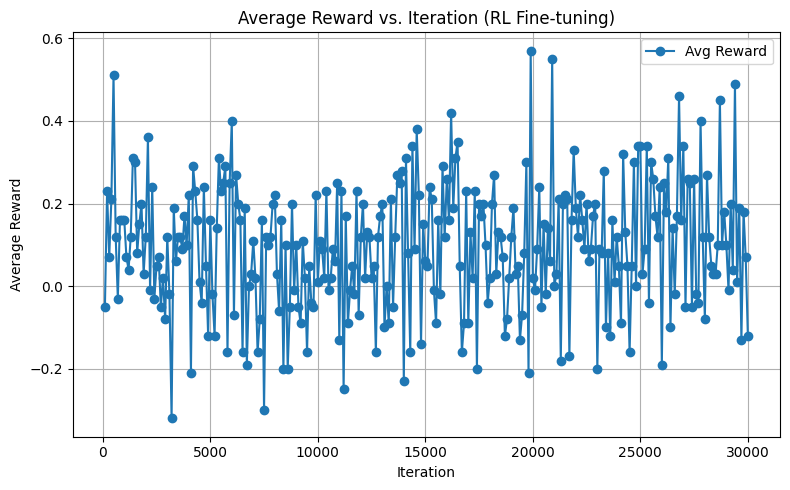

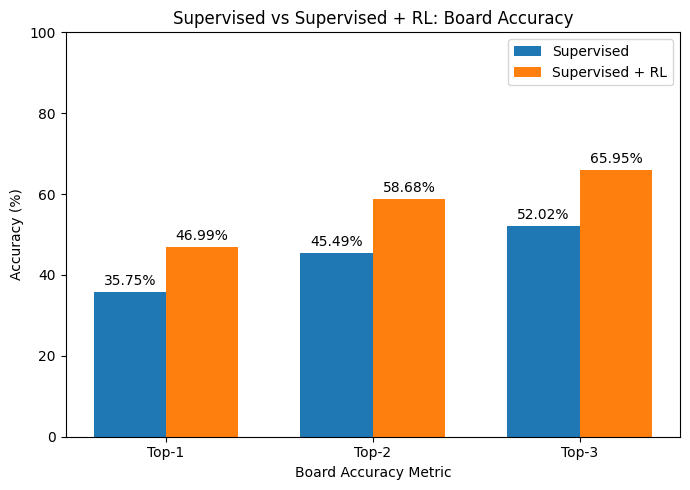

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

supervised_acc = [35.75, 45.49, 52.02]
rl_acc = [46.99, 58.68, 65.95]

labels = ['Top-1', 'Top-2', 'Top-3']
x = np.arange(len(labels))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(7,5))

rects1 = ax.bar(x - bar_width/2, supervised_acc, bar_width, label='Supervised')
rects2 = ax.bar(x + bar_width/2, rl_acc, bar_width, label='Supervised + RL')

ax.set_xlabel('Board Accuracy Metric')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Supervised vs Supervised + RL: Board Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0, 100)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


In [ ]:
import torch
import random

model = MiniTransformerModel(
    vocab_size=len(word2id),
    embed_dim=128,
    n_heads=4,
    n_layers=3,
    pad_idx=0,
    board_size=25
)
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/nlp project/guesser_wordnet_supervised_RL.pth', map_location=device))
model.to(device)
model.eval()


def play_demo_board(model, word2id, id2word, clue_targets, vocab, num_targets=2):
    clue = random.choice(list(clue_targets.keys()))
    board_words, target_words, N = sample_board(clue)
    print("\n🧩 Board words:")
    print(board_words)
    print(f"\n🔑 Clue: \"{clue}\"  (Targets to guess: {N})")
    print(f"Target words (hidden): {target_words}")

    seq_tokens = [clue] + board_words
    seq_ids = [word2id.get(token, 0) for token in seq_tokens]
    seq_tensor = torch.tensor(seq_ids, dtype=torch.long, device=device).unsqueeze(0)  # shape: [1, 26]

    with torch.no_grad():
        logits = model(seq_tensor)  # [1, 25]
        probs = torch.sigmoid(logits[0]).cpu().numpy()  # shape: [25]

    top_indices = probs.argsort()[-N:][::-1]
    guesses = [board_words[i] for i in top_indices]

    print(f"\n🤖 Model's guesses (Top-{N}): {guesses}")

    correct = [w for w in guesses if w in target_words]
    wrong = [w for w in guesses if w not in target_words]
    print(f"✅ Correct guesses: {correct}")
    print(f"❌ Wrong guesses: {wrong}")
    print(f"🎯 Accuracy: {len(correct)}/{N} ({100*len(correct)/N:.1f}%)")


play_demo_board(model, word2id, id2word, clue_targets, vocab)


🧩 Board words:
['checkerberry', 'actinotherapy', 'scd', 'de-stalinisation', 'battercake', 'pacifier', 'monkshood', 'garishness', 'progressive', 'loose-fitting', 'gaudiness', 'hajji', 'homosexual', 'excogitation', 'uninitiate', 'topminnow', 'backspace key', 'high temperature', 'gratis', 'dazzle', 'enroll', 'boggy', 'element 104', 'liquidiser', 'bedraggled']

🔑 Clue: "flashiness"  (Targets to guess: 2)
Target words (hidden): ['garishness', 'gaudiness']

🤖 Model's guesses (Top-2): ['gaudiness', 'garishness']
✅ Correct guesses: ['gaudiness', 'garishness']
❌ Wrong guesses: []
🎯 Accuracy: 2/2 (100.0%)


In [ ]:
import torch
import random

model = MiniTransformerModel(
    vocab_size=len(word2id),
    embed_dim=128,
    n_heads=4,
    n_layers=3,
    pad_idx=0,
    board_size=25
)
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/nlp project/guesser_wordnet_supervised_RL.pth', map_location=device))
model.to(device)
model.eval()


def play_demo_board(model, word2id, id2word, clue_targets, vocab, num_targets=2):
    clue = random.choice(list(clue_targets.keys()))
    board_words, target_words, N = sample_board(clue)
    print("\n🧩 Board words:")
    print(board_words)
    print(f"\n🔑 Clue: \"{clue}\"  (Targets to guess: {N})")
    print(f"Target words (hidden): {target_words}")

    seq_tokens = [clue] + board_words
    seq_ids = [word2id.get(token, 0) for token in seq_tokens]
    seq_tensor = torch.tensor(seq_ids, dtype=torch.long, device=device).unsqueeze(0)  # shape: [1, 26]

    with torch.no_grad():
        logits = model(seq_tensor)  # [1, 25]
        probs = torch.sigmoid(logits[0]).cpu().numpy()  # shape: [25]

    top_indices = probs.argsort()[-N:][::-1]
    guesses = [board_words[i] for i in top_indices]

    print(f"\n🤖 Model's guesses (Top-{N}): {guesses}")

    correct = [w for w in guesses if w in target_words]
    wrong = [w for w in guesses if w not in target_words]
    print(f"✅ Correct guesses: {correct}")
    print(f"❌ Wrong guesses: {wrong}")
    print(f"🎯 Accuracy: {len(correct)}/{N} ({100*len(correct)/N:.1f}%)")


play_demo_board(model, word2id, id2word, clue_targets, vocab)


🧩 Board words:
['petiteness', 'anteriority', 'uzbekistan', 'trilling', 'key fruit', 'draggled', 'pituitary gland', 'kidnaper', 'stuffing', 'phenergan', 'buncombe', 'tympanic membrane', 'energize', 'acetaminophen', 'bunk', 'spook', 'lend', 'sprightliness', 'khat', 'madrona', 'victoria', 'bunkum', 'guiltless', 'chew up', 'tocainide']

🔑 Clue: "guff"  (Targets to guess: 3)
Target words (hidden): ['bunk', 'bunkum', 'buncombe']

🤖 Model's guesses (Top-3): ['buncombe', 'bunk', 'kidnaper']
✅ Correct guesses: ['buncombe', 'bunk']
❌ Wrong guesses: ['kidnaper']
🎯 Accuracy: 2/3 (66.7%)


In [ ]:
import torch
import random

model = MiniTransformerModel(
    vocab_size=len(word2id),
    embed_dim=128,
    n_heads=4,
    n_layers=3,
    pad_idx=0,
    board_size=25
)
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/nlp project/guesser_wordnet_supervised_RL.pth', map_location=device))
model.to(device)
model.eval()


def play_demo_board(model, word2id, id2word, clue_targets, vocab, num_targets=2):
    clue = random.choice(list(clue_targets.keys()))
    board_words, target_words, N = sample_board(clue)
    print("\n🧩 Board words:")
    print(board_words)
    print(f"\n🔑 Clue: \"{clue}\"  (Targets to guess: {N})")
    print(f"Target words (hidden): {target_words}")

    seq_tokens = [clue] + board_words
    seq_ids = [word2id.get(token, 0) for token in seq_tokens]
    seq_tensor = torch.tensor(seq_ids, dtype=torch.long, device=device).unsqueeze(0)  # shape: [1, 26]

    with torch.no_grad():
        logits = model(seq_tensor)  # [1, 25]
        probs = torch.sigmoid(logits[0]).cpu().numpy()  # shape: [25]

    top_indices = probs.argsort()[-N:][::-1]
    guesses = [board_words[i] for i in top_indices]

    print(f"\n🤖 Model's guesses (Top-{N}): {guesses}")

    correct = [w for w in guesses if w in target_words]
    wrong = [w for w in guesses if w not in target_words]
    print(f"✅ Correct guesses: {correct}")
    print(f"❌ Wrong guesses: {wrong}")
    print(f"🎯 Accuracy: {len(correct)}/{N} ({100*len(correct)/N:.1f}%)")


play_demo_board(model, word2id, id2word, clue_targets, vocab)


🧩 Board words:
['sphaerocarpos', 'hurdle', 'thorny', 'glassware', 'rhine', 'appellation', 'ill-timed', 'throw', 'mozartian', 'kerb', 'hired gun', 'marbleising', 'laic', 'impede', 'nilgai', 'normal', 'denomination', 'dotty', 'anas clypeata', 'citellus', 'parsons', 'sensitised', 'vitalize', 'mystery story', 'boche']

🔑 Clue: "designation"  (Targets to guess: 2)
Target words (hidden): ['appellation', 'denomination']

🤖 Model's guesses (Top-2): ['nilgai', 'appellation']
✅ Correct guesses: ['appellation']
❌ Wrong guesses: ['nilgai']
🎯 Accuracy: 1/2 (50.0%)


In [ ]:
def play_user_clue_board(model, word2id, id2word, clue_targets, vocab):
    clue = random.choice(list(clue_targets.keys()))
    board_words, target_words, N = sample_board(clue)
    print("\n🧩 Board words:")
    print(", ".join(board_words))

    user_input = input("\nEnter your clue and number (e.g., flashiness 2): ").strip().lower()
    while True:
        try:
            clue_word, num_str = user_input.rsplit(" ", 1)
            clue_word = clue_word.strip()
            clue_num = int(num_str)
            if clue_word not in clue_targets:
                raise ValueError
            if not (1 <= clue_num <= len(board_words)):
                raise ValueError
            break
        except Exception:
            user_input = input("Invalid. Enter your clue and number (e.g., flashiness 2): ").strip().lower()

    print(f"\n🔑 Your clue: \"{clue_word}\"  (Targets to guess: {clue_num})")

    seq_tokens = [clue_word] + board_words
    seq_ids = [word2id.get(token, 0) for token in seq_tokens]
    seq_tensor = torch.tensor(seq_ids, dtype=torch.long, device=device).unsqueeze(0)

    with torch.no_grad():
        logits = model(seq_tensor)
        probs = torch.sigmoid(logits[0]).cpu().numpy()

    top_indices = probs.argsort()[-clue_num:][::-1]
    guesses = [board_words[i] for i in top_indices]

    print(f"\n🤖 Model's guesses (Top-{clue_num}): {guesses}")
    print(f"(Targets were: {target_words})")

    correct = [w for w in guesses if w in target_words]
    wrong = [w for w in guesses if w not in target_words]
    print(f"✅ Correct guesses: {correct}")
    print(f"❌ Wrong guesses: {wrong}")
    print(f"🎯 Accuracy: {len(correct)}/{clue_num} ({100*len(correct)/clue_num:.1f}%)")

play_user_clue_board(model, word2id, id2word, clue_targets, vocab)



🧩 Board words:
cichorium endivia, heraldic bearing, line, buy, pass water, whine, discoverer, eff, grim, justifier, swelling, skank, pigfish, sarcostyle, azactam, buffeted, radiotherapy, delimitation, debarkation, bather, descent, auditory, forbiddance, rabbit on, lineage

Enter your clue and number (e.g., flashiness 2): drink 2

🔑 Your clue: "drink"  (Targets to guess: 2)

🤖 Model's guesses (Top-2): ['lineage', 'line']
(Targets were: ['lineage', 'line', 'descent'])
✅ Correct guesses: ['lineage', 'line']
❌ Wrong guesses: []
🎯 Accuracy: 2/2 (100.0%)


In [ ]:
def play_user_clue_board(model, word2id, id2word, clue_targets, vocab):
    clue = random.choice(list(clue_targets.keys()))
    board_words, target_words, N = sample_board(clue)
    print("\n🧩 Board words:")
    print(", ".join(board_words))

    user_input = input("\nEnter your clue and number (e.g., flashiness 2): ").strip().lower()
    while True:
        try:
            clue_word, num_str = user_input.rsplit(" ", 1)
            clue_word = clue_word.strip()
            clue_num = int(num_str)
            if clue_word not in clue_targets:
                raise ValueError
            if not (1 <= clue_num <= len(board_words)):
                raise ValueError
            break
        except Exception:
            user_input = input("Invalid. Enter your clue and number (e.g., flashiness 2): ").strip().lower()

    print(f"\n🔑 Your clue: \"{clue_word}\"  (Targets to guess: {clue_num})")

    seq_tokens = [clue_word] + board_words
    seq_ids = [word2id.get(token, 0) for token in seq_tokens]
    seq_tensor = torch.tensor(seq_ids, dtype=torch.long, device=device).unsqueeze(0)

    with torch.no_grad():
        logits = model(seq_tensor)
        probs = torch.sigmoid(logits[0]).cpu().numpy()

    top_indices = probs.argsort()[-clue_num:][::-1]
    guesses = [board_words[i] for i in top_indices]

    print(f"\n🤖 Model's guesses (Top-{clue_num}): {guesses}")
    print(f"(Targets were: {target_words})")

    correct = [w for w in guesses if w in target_words]
    wrong = [w for w in guesses if w not in target_words]
    print(f"✅ Correct guesses: {correct}")
    print(f"❌ Wrong guesses: {wrong}")
    print(f"🎯 Accuracy: {len(correct)}/{clue_num} ({100*len(correct)/clue_num:.1f}%)")


play_user_clue_board(model, word2id, id2word, clue_targets, vocab)


🧩 Board words:
indenture, subdue, suppress, lachrymator, homely, picky, rub out, crepuscule, indescribable, inhibit, untainted, overwhelming, hair style, eurotiales, biological warfare, vacuolization, empennage, localisation, serb, bibulous, storekeeper, specially, totalisator, depend, microchip


KeyboardInterrupt: Interrupted by user

In [ ]:
def play_user_clue_board(model, word2id, id2word, clue_targets, vocab):
    clue = random.choice(list(clue_targets.keys()))
    board_words, target_words, N = sample_board(clue)
    print("\n🧩 Board words:")
    print(", ".join(board_words))

    user_input = input("\nEnter your clue and number (e.g., flashiness 2): ").strip().lower()
    while True:
        try:
            clue_word, num_str = user_input.rsplit(" ", 1)
            clue_word = clue_word.strip()
            clue_num = int(num_str)
            if clue_word not in clue_targets:
                raise ValueError
            if not (1 <= clue_num <= len(board_words)):
                raise ValueError
            break
        except Exception:
            user_input = input("Invalid. Enter your clue and number (e.g., flashiness 2): ").strip().lower()

    print(f"\n🔑 Your clue: \"{clue_word}\"  (Targets to guess: {clue_num})")

    seq_tokens = [clue_word] + board_words
    seq_ids = [word2id.get(token, 0) for token in seq_tokens]
    seq_tensor = torch.tensor(seq_ids, dtype=torch.long, device=device).unsqueeze(0)

    with torch.no_grad():
        logits = model(seq_tensor)
        probs = torch.sigmoid(logits[0]).cpu().numpy()

    top_indices = probs.argsort()[-clue_num:][::-1]
    guesses = [board_words[i] for i in top_indices]

    print(f"\n🤖 Model's guesses (Top-{clue_num}): {guesses}")
    print(f"(Targets were: {target_words})")

    correct = [w for w in guesses if w in target_words]
    wrong = [w for w in guesses if w not in target_words]
    print(f"✅ Correct guesses: {correct}")
    print(f"❌ Wrong guesses: {wrong}")
    print(f"🎯 Accuracy: {len(correct)}/{clue_num} ({100*len(correct)/clue_num:.1f}%)")


play_user_clue_board(model, word2id, id2word, clue_targets, vocab)


🧩 Board words:
fusty, badger dog, black, humorless, digger, polychete worm, dec, reprehension, impuissance, cyclobenzaprine, ignominious, aneurysmal, hepatoflavin, bos taurus, disgraceful, saltwort, drinker, epidermic, ionic, order rhoeadales, activating, 1000000, extend, nonparallel, amusing

Enter your clue and number (e.g., flashiness 2): s 2

🔑 Your clue: "s"  (Targets to guess: 2)

🤖 Model's guesses (Top-2): ['black', 'extend']
(Targets were: ['black', 'disgraceful', 'ignominious'])
✅ Correct guesses: ['black']
❌ Wrong guesses: ['extend']
🎯 Accuracy: 1/2 (50.0%)


In [ ]:
def play_user_clue_codenames(model, word2id, id2word, vocab, board_size=25, blue_num=8, red_num=8, neutral_num=8, assassin_num=1):

    all_words = list(vocab)
    board_words = random.sample(all_words, board_size)

    roles = (['blue'] * blue_num) + (['red'] * red_num) + (['neutral'] * neutral_num) + (['assassin'] * assassin_num)
    roles += ['neutral'] * (board_size - len(roles))
    random.shuffle(roles)

    word_roles = {w: r for w, r in zip(board_words, roles)}
    blue_words = [w for w, r in word_roles.items() if r == 'blue']
    red_words = [w for w, r in word_roles.items() if r == 'red']
    neutral_words = [w for w, r in word_roles.items() if r == 'neutral']
    assassin_words = [w for w, r in word_roles.items() if r == 'assassin']

    print("\n🟦 Blue words:\n", ", ".join(blue_words))
    print("\n🟥 Red words:\n", ", ".join(red_words))
    print("\n🟫 Neutral words:\n", ", ".join(neutral_words))
    if assassin_words:
        print("\n☠️ Assassin word:\n", ", ".join(assassin_words))

    print("\nFull Board:")
    print(", ".join(board_words))

    user_input = input("\nEnter your clue and number (e.g., animal 2): ").strip().lower()
    while True:
        try:
            clue_word, num_str = user_input.rsplit(" ", 1)
            clue_word = clue_word.strip()
            clue_num = int(num_str)

            if not (1 <= clue_num <= len(blue_words)):
                raise ValueError
            break
        except Exception:
            user_input = input("Invalid. Enter your clue and number (e.g., animal 2): ").strip().lower()

    print(f"\n🔑 Your clue: \"{clue_word}\" ({clue_num})")

    seq_tokens = [clue_word] + board_words
    seq_ids = [word2id.get(token, 0) for token in seq_tokens]
    seq_tensor = torch.tensor(seq_ids, dtype=torch.long, device=device).unsqueeze(0)

    with torch.no_grad():
        logits = model(seq_tensor)
        probs = torch.sigmoid(logits[0]).cpu().numpy()

    top_indices = probs.argsort()[-clue_num:][::-1]
    guesses = [board_words[i] for i in top_indices]

    print(f"\n🤖 Model's guesses (Top-{clue_num}): {guesses}")


play_user_clue_codenames(model, word2id, id2word, vocab)


🟦 Blue words:
 time lag, marshals, suspect, purposely, italia, hawse, spume, doha

🟥 Red words:
 pliability, greenness, pelf, prognosis, sever, yap away, preoccupied, cewa

🟫 Neutral words:
 torturous, modiste, moralizing, shangri-la, buckaroo, haymow, gown, dowse

☠️ Assassin word:
 disinterment

Full Board:
pliability, time lag, greenness, disinterment, marshals, torturous, pelf, suspect, modiste, purposely, moralizing, shangri-la, buckaroo, italia, prognosis, haymow, gown, hawse, spume, sever, yap away, preoccupied, doha, cewa, dowse

Enter your clue and number (e.g., animal 2): criminal 2

🔑 Your clue: "criminal" (2)

🤖 Model's guesses (Top-2): ['preoccupied', 'suspect']


In [ ]:
def play_user_clue_codenames(model, word2id, id2word, vocab, board_size=25, blue_num=8, red_num=8, neutral_num=8, assassin_num=1):
    all_words = list(vocab)
    board_words = random.sample(all_words, board_size)

    roles = (['blue'] * blue_num) + (['red'] * red_num) + (['neutral'] * neutral_num) + (['assassin'] * assassin_num)
    roles += ['neutral'] * (board_size - len(roles))
    random.shuffle(roles)

    word_roles = {w: r for w, r in zip(board_words, roles)}
    blue_words = [w for w, r in word_roles.items() if r == 'blue']
    red_words = [w for w, r in word_roles.items() if r == 'red']
    neutral_words = [w for w, r in word_roles.items() if r == 'neutral']
    assassin_words = [w for w, r in word_roles.items() if r == 'assassin']

    print("\n🟦 Blue words:\n", ", ".join(blue_words))
    print("\n🟥 Red words:\n", ", ".join(red_words))
    print("\n🟫 Neutral words:\n", ", ".join(neutral_words))
    if assassin_words:
        print("\n☠️ Assassin word:\n", ", ".join(assassin_words))

    print("\nFull Board:")
    print(", ".join(board_words))

    user_input = input("\nEnter your clue and number (e.g., animal 2): ").strip().lower()
    while True:
        try:
            clue_word, num_str = user_input.rsplit(" ", 1)
            clue_word = clue_word.strip()
            clue_num = int(num_str)

            if not (1 <= clue_num <= len(blue_words)):
                raise ValueError
            break
        except Exception:
            user_input = input("Invalid. Enter your clue and number (e.g., animal 2): ").strip().lower()

    print(f"\n🔑 Your clue: \"{clue_word}\" ({clue_num})")

    seq_tokens = [clue_word] + board_words
    seq_ids = [word2id.get(token, 0) for token in seq_tokens]
    seq_tensor = torch.tensor(seq_ids, dtype=torch.long, device=device).unsqueeze(0)

    with torch.no_grad():
        logits = model(seq_tensor)
        probs = torch.sigmoid(logits[0]).cpu().numpy()

    top_indices = probs.argsort()[-clue_num:][::-1]
    guesses = [board_words[i] for i in top_indices]

    print(f"\n🤖 Model's guesses (Top-{clue_num}): {guesses}")


play_user_clue_codenames(model, word2id, id2word, vocab)


🟦 Blue words:
 volley, brachycephalic, percentage, lawbreaker, deep brown, try, tallith, deftly

🟥 Red words:
 split, extraction, carabinier, pollyfish, pinch, iyar, roily, popsicle

🟫 Neutral words:
 subdivision pinophytina, injure, normodyne, intrepidly, antecede, fret, course of instruction, mindset

☠️ Assassin word:
 nominate

Full Board:
split, extraction, carabinier, pollyfish, volley, subdivision pinophytina, injure, normodyne, brachycephalic, pinch, percentage, iyar, intrepidly, antecede, roily, lawbreaker, fret, deep brown, try, tallith, course of instruction, deftly, popsicle, mindset, nominate

Enter your clue and number (e.g., animal 2): mathematic 2

🔑 Your clue: "mathematic" (2)

🤖 Model's guesses (Top-2): ['nominate', 'pinch']
